<a href="https://colab.research.google.com/github/aakarshhh/AI_ML/blob/main/Model_Update_StockLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance 

     |████████████████████████████████| 6.3MB 8.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=13773cd8e067cc279ef9b9079f0264a1c520ceabc3c889263ceba138c40e83d2
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as dr
import datetime as dt 
import yfinance as yf
import tensorflow as tf
import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import  Dense , Dropout ,LSTM ,BatchNormalization

In [3]:
pred_days = 8
d= dt.timedelta(days = 18)
start = dt.datetime.now()- d 
end = dt.datetime.now()
start, end

(datetime.datetime(2021, 4, 23, 11, 21, 51, 221591),
 datetime.datetime(2021, 5, 11, 11, 21, 51, 221656))

In [4]:
company=''
for i in pd.read_excel('/content/drive/MyDrive/SentStock/tickers.xlsx',header=None)[0] :
  company+=str(i).strip()+' '
company  
data = yf.download(
        tickers = f'{company}',
        start =start, end=end,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True)
data = pd.DataFrame(data)
data = data[-(pred_days+1):]
param = pd.read_csv('/content/drive/MyDrive/SentStock/param.csv',header=0).rename(index={0:'mean',1:'std',2:'pred', 3:'real',4:'pred_next'})

[*********************100%***********************]  78 of 78 completed


In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
model= Sequential()
model.add(Dense(16, activation='relu',input_shape= ( pred_days , 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(LSTM( units = 16 , return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(units = 64 ,return_sequences=True , recurrent_dropout=0.2))
model.add(LSTM(units = 32  , recurrent_dropout=0.15))
model.add(Dense(8, activation='relu'))
model.add(Dense(units = 1))
model.compile(loss = 'mse' , optimizer = 'adam' )

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8, 16)             32        
_________________________________________________________________
dense_1 (Dense)              (None, 8, 32)             544       
_________________________________________________________________
dense_2 (Dense)              (None, 8, 16)             528       
_________________________________________________________________
lstm (LSTM)                  (None, 8, 16)             2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 64)             20736     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2

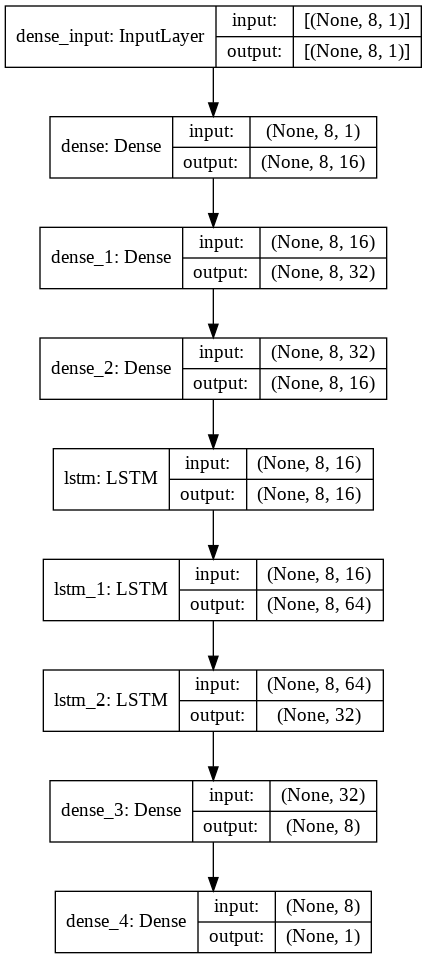

In [10]:
import IPython
keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

In [ ]:
model.load_weights('/content/drive/MyDrive/SentStock/stock_lstm.keras')

In [ ]:
sc = StandardScaler()
from numpy import arange
def train_model(x,y,ep = 7):
  model.fit(x,y, epochs=ep , batch_size = 1 , verbose=2 )

def save_plot(y,p,name = "default"):
  plt.figure(dpi=100)
  plt.plot(y,color="black",label = "Actual Data")
  plt.plot(p, color="green",label = "Predicted Data")
  plt.legend() 
  plt.savefig(fname = f'/content/drive/MyDrive/SentStock/Pred/{name}_'+end.strftime("%m_%d_%Y")+'.jpeg')
  plt.show()

def norm(x , c ):
  sc.mean_= param[f'{c}']['mean']
  sc.scale_= param[f'{c}']['std']
  return sc.transform(x)

def scaled(y , c ):
  sc.mean_= param[f'{c}']['mean']
  sc.scale_= param[f'{c}']['std']
  return sc.inverse_transform(y)
def save_plot(d,c,name = "default"):
  d = d[3:]
  x=np.linspace(1.0, 12.0, num =30) 
  plt.figure(dpi=100)
  plt.plot(d, color="green",label = "Predicted Data")
  plt.plot(d[:6],color="black",label = "Actual Data")
  plt.legend()
  x=[i for i in range(0,15)]
  for i,j in zip(x[5:],d[5:]):
    if i % 2:
      plt.annotate(str(round(j[0],3)),xy=(i,j+.2*param[f'{c}']['std']))        
    else:
      plt.annotate(str(round(j[0],3)),xy=(i,j-.2*param[f'{c}']['std']))
  plt.savefig(fname = f'/content/drive/MyDrive/SentStock/Pred/{name}_'+end.strftime("%m_%d_%Y")+'.jpeg')
  plt.show()

In [ ]:
param

,T,TMUS,USM,VZ,AAPL,MSFT,AMZN,GOOGL,FB,V,NVDA,MA,PYPL,NFLX,BRK-B,JPM,BAC,WFC,MS,C,BLK,AMT,PLD,CCI,EQIX,SPG,PSA,WELL,EQR,AVB,SBAC,XOM,CVX,NEP,SO,D,DUK,COP,AEP,KMI,EXC,CVS,UNH,MCK,ABC,CI,CAH,ANTM,JNJ,CNC,HUM,THO,ALGN,PPC,PATK,LCII,SHW,SAFM,LEA,CLX,LANC,DIS,CMCSA,NKE,CHTR,SNE,ATVI,MAR,LVS,VIAC,BTI,MO,DEO,EL,BUD,PM,PEP,KO,PG,GME
mean,31.622778,133.736111,35.441112,57.900555,131.267223,252.209998,3375.855577,2339.152262,317.862773,232.311113,595.554443,381.181115,259.187246,505.168877,280.209971,155.647778,40.962777,45.675716,83.819252,72.996921,837.309998,250.177780,115.322222,185.077777,708.134454,122.614722,276.967224,75.011112,73.433334,192.012221,295.855554,59.289255,106.387221,72.118865,65.595000,78.841112,99.976112,53.582778,87.861122,17.295757,44.592777,79.316112,405.745551,190.282778,120.813334,253.876668,60.001667,385.256110,165.393334,63.398889,453.784444,144.736664,596.428894,24.454445,94.300000,148.695001,278.105554,166.461226,189.525555,183.866225,186.346666,184.144443,56.192778,132.990557,671.585551,106.551250,91.560555,147.597777,59.969444,40.327778,38.151111,48.080000,180.740000,305.457218,71.588295,95.473334,144.187778,54.126111,133.546665,167.835554
std,0.531680,3.321217,0.895364,0.986938,2.277906,4.216371,76.799990,29.204025,7.787910,2.115934,14.675119,8.025909,8.287978,4.949230,6.153723,3.345771,0.753927,0.617786,2.022422,1.226059,19.944170,3.004329,1.007005,2.532662,7.709247,1.075514,2.518025,1.241946,0.765970,2.090721,2.975799,1.876149,2.437199,2.141679,0.777096,0.856018,0.907670,1.952826,0.657468,0.308625,0.406114,3.676833,8.289004,3.479182,2.468382,4.854248,1.594219,6.742386,2.350853,3.035898,9.154408,1.926159,15.212807,0.250161,2.358691,2.680247,6.562798,4.230354,4.504106,1.731514,2.405883,1.513263,1.202607,1.931296,11.966063,3.049043,1.662186,2.568170,1.537137,1.377984,0.775320,1.039541,1.534434,9.736564,1.792830,1.021490,1.251360,0.354367,1.487544,7.908046
pred,32.302002,138.986038,36.576622,58.889397,130.121994,252.657349,3283.211426,2361.536133,318.231964,231.704941,595.640198,378.426758,253.511917,501.634644,287.744781,160.695740,42.206772,46.664242,87.491982,75.184700,871.517944,248.181152,115.046379,183.839188,708.366516,124.572258,277.034576,74.784988,74.137535,195.329468,292.073273,61.956188,109.998711,68.731735,66.371391,78.512505,101.241753,57.131157,87.902641,17.787172,44.554314,84.326759,417.714508,192.203735,122.717064,262.810455,58.924793,396.188812,168.968506,68.635551,468.022064,146.874527,595.455261,24.336378,97.566078,147.905106,285.338104,170.941040,194.548798,185.007187,188.583588,183.255310,57.592461,135.596222,690.932190,105.053230,94.625977,146.560516,58.904499,39.631393,39.754658,50.101528,183.232941,303.149994,74.760544,97.333855,145.793869,54.569309,135.511963,163.621597
real,32.165001,139.544998,36.480000,58.744999,130.264999,252.820007,3292.770020,2354.060059,319.524994,231.850006,593.500000,374.970001,253.965195,504.059998,290.829712,161.300003,42.154999,46.525002,87.750000,74.980003,872.219971,248.059998,115.809998,183.089996,711.950012,124.602501,276.565002,74.440002,73.879997,194.649994,290.920013,62.373299,109.974998,68.580002,66.385002,78.510002,100.974998,57.185001,87.370102,17.825001,44.674999,85.014999,417.559998,197.485001,121.050003,261.160004,58.235001,396.654999,168.660004,70.000000,464.450012,145.860001,596.979980,24.280001,97.349998,146.365005,287.109985,171.729996,194.970001,183.026001,188.710007,184.860001,58.195000,137.934998,694.900024,100.160004,94.964996,146.039993,57.674999,39.310001,39.860001,49.970001,183.250000,302.964996,74.660004,97.489998,145.669998,54.564999,135.270004,160.970001
pred_next,32.128365,137.596208,36.330862,58.404465,133.821027,259.876323,3373.733896,2358.776511,307.568048,233.268055,610.167660,386.515748,261.988048,506.722639,285.322321,158.886660,41.762513,46.336734,86.198550,74.444811,860.038278,250.177293,116.193861,185.313381,721.732294,124.270104,278.639903,76.016574,75.161133,195.427566,293.485567,60.873829,108.556751,69.722740,6

In [ ]:
a =param
a=pd.concat((a ,param.loc[['real','pred','pred_next']]))
a.reset_index(drop=True, inplace=True)
a= a.rename(index={0:'real',1:'pred',2:'pred_next', 3:'pred_next2',4:'pred_next3',5:'pred_next4',6:'pred_next5',7:'pred_next6'})

Training started for T
Epoch 1/7
1/1 - 5s - loss: 0.3484
Epoch 2/7
1/1 - 0s - loss: 0.2840
Epoch 3/7
1/1 - 0s - loss: 0.1204
Epoch 4/7
1/1 - 0s - loss: 0.1570
Epoch 5/7
1/1 - 0s - loss: 0.0917
Epoch 6/7
1/1 - 0s - loss: 0.0801
Epoch 7/7
1/1 - 0s - loss: 0.1314
((1, 8, 1), (1, 1, 1), 'T')


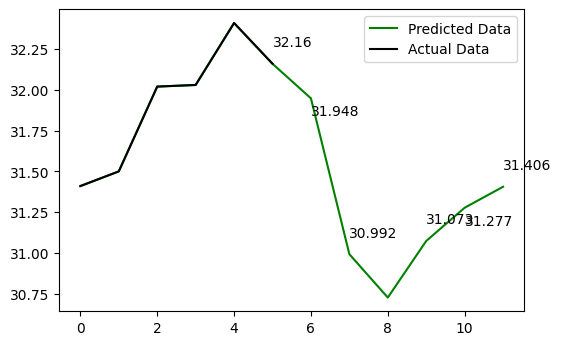

Training ended for T
1

Training started for TMUS
Epoch 1/7
1/1 - 0s - loss: 8.7014e-05
Epoch 2/7
1/1 - 0s - loss: 8.8192e-05
Epoch 3/7
1/1 - 0s - loss: 0.0721
Epoch 4/7
1/1 - 0s - loss: 0.0131
Epoch 5/7
1/1 - 0s - loss: 0.0392
Epoch 6/7
1/1 - 0s - loss: 0.0185
Epoch 7/7
1/1 - 0s - loss: 0.0301
((1, 8, 1), (1, 1, 1), 'TMUS')


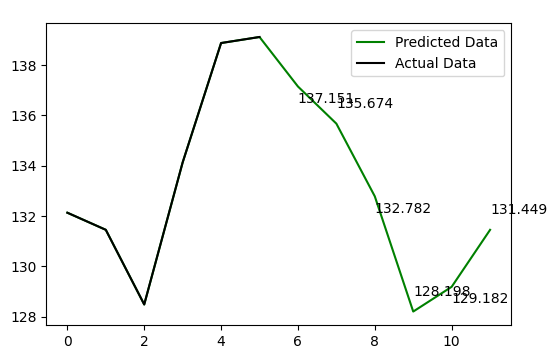

Training ended for TMUS
2

Training started for USM
Epoch 1/7
1/1 - 0s - loss: 0.0035
Epoch 2/7
1/1 - 0s - loss: 0.0850
Epoch 3/7
1/1 - 0s - loss: 0.0802
Epoch 4/7
1/1 - 0s - loss: 0.0145
Epoch 5/7
1/1 - 0s - loss: 0.0027
Epoch 6/7
1/1 - 0s - loss: 0.0110
Epoch 7/7
1/1 - 0s - loss: 0.0200
((1, 8, 1), (1, 1, 1), 'USM')


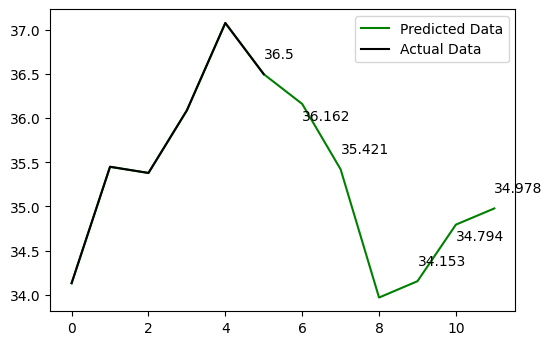

Training ended for USM
3

Training started for VZ
Epoch 1/7
1/1 - 0s - loss: 0.0076
Epoch 2/7
1/1 - 0s - loss: 0.0033
Epoch 3/7
1/1 - 0s - loss: 0.0128
Epoch 4/7
1/1 - 0s - loss: 0.0105
Epoch 5/7
1/1 - 0s - loss: 0.0077
Epoch 6/7
1/1 - 0s - loss: 0.0012
Epoch 7/7
1/1 - 0s - loss: 9.2864e-05
((1, 8, 1), (1, 1, 1), 'VZ')


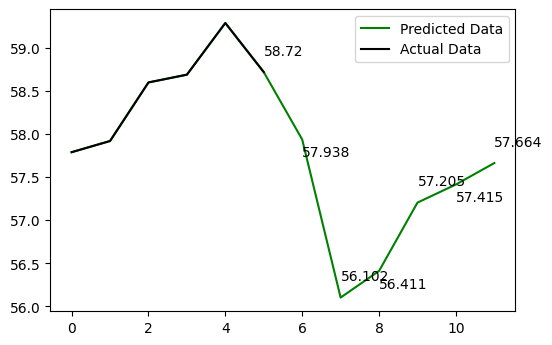

Training ended for VZ
4

Training started for AAPL
Epoch 1/7
1/1 - 0s - loss: 0.0523
Epoch 2/7
1/1 - 0s - loss: 0.0158
Epoch 3/7
1/1 - 0s - loss: 0.0485
Epoch 4/7
1/1 - 0s - loss: 0.0214
Epoch 5/7
1/1 - 0s - loss: 0.0159
Epoch 6/7
1/1 - 0s - loss: 0.0057
Epoch 7/7
1/1 - 0s - loss: 0.0115
((1, 8, 1), (1, 1, 1), 'AAPL')


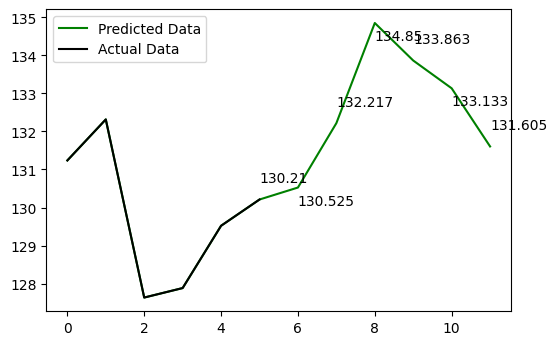

Training ended for AAPL
5

Training started for MSFT
Epoch 1/7
1/1 - 0s - loss: 0.1664
Epoch 2/7
1/1 - 0s - loss: 0.2153
Epoch 3/7
1/1 - 0s - loss: 0.1820
Epoch 4/7
1/1 - 0s - loss: 0.1387
Epoch 5/7
1/1 - 0s - loss: 0.1268
Epoch 6/7
1/1 - 0s - loss: 0.1218
Epoch 7/7
1/1 - 0s - loss: 0.1374
((1, 8, 1), (1, 1, 1), 'MSFT')


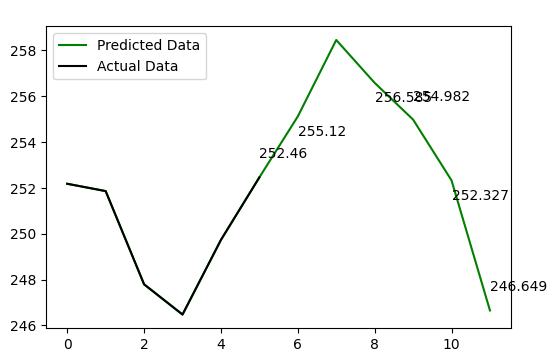

Training ended for MSFT
6

Training started for AMZN
Epoch 1/7
1/1 - 0s - loss: 0.4131
Epoch 2/7
1/1 - 0s - loss: 0.5689
Epoch 3/7
1/1 - 0s - loss: 0.4639
Epoch 4/7
1/1 - 0s - loss: 0.6113
Epoch 5/7
1/1 - 0s - loss: 0.4990
Epoch 6/7
1/1 - 0s - loss: 0.6210
Epoch 7/7
1/1 - 0s - loss: 0.5508
((1, 8, 1), (1, 1, 1), 'AMZN')


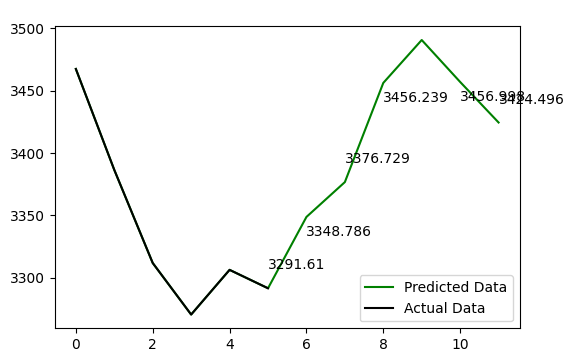

Training ended for AMZN
7

Training started for GOOGL
Epoch 1/7
1/1 - 0s - loss: 0.2340
Epoch 2/7
1/1 - 0s - loss: 0.2649
Epoch 3/7
1/1 - 0s - loss: 0.2403
Epoch 4/7
1/1 - 0s - loss: 0.2586
Epoch 5/7
1/1 - 0s - loss: 0.1700
Epoch 6/7
1/1 - 0s - loss: 0.1918
Epoch 7/7
1/1 - 0s - loss: 0.0852
((1, 8, 1), (1, 1, 1), 'GOOGL')


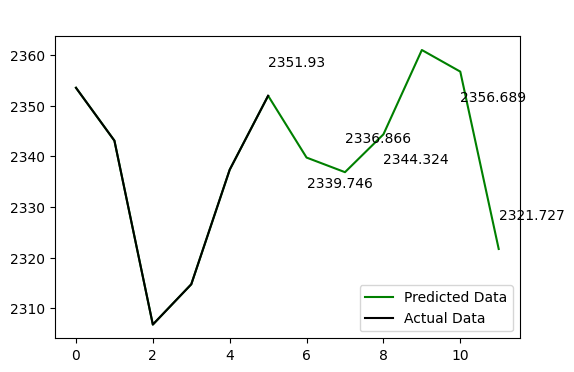

Training ended for GOOGL
8

Training started for FB
Epoch 1/7
1/1 - 0s - loss: 0.2419
Epoch 2/7
1/1 - 0s - loss: 0.3021
Epoch 3/7
1/1 - 0s - loss: 0.3521
Epoch 4/7
1/1 - 0s - loss: 0.2340
Epoch 5/7
1/1 - 0s - loss: 0.0988
Epoch 6/7
1/1 - 0s - loss: 0.0066
Epoch 7/7
1/1 - 0s - loss: 0.0029
((1, 8, 1), (1, 1, 1), 'FB')


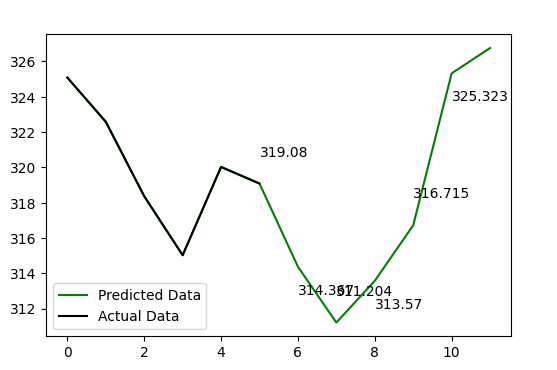

Training ended for FB
9

Training started for V
Epoch 1/7
1/1 - 0s - loss: 0.0474
Epoch 2/7
1/1 - 0s - loss: 0.1100
Epoch 3/7
1/1 - 0s - loss: 0.0526
Epoch 4/7
1/1 - 0s - loss: 0.0166
Epoch 5/7
1/1 - 0s - loss: 0.0066
Epoch 6/7
1/1 - 0s - loss: 0.0406
Epoch 7/7
1/1 - 0s - loss: 0.0467
((1, 8, 1), (1, 1, 1), 'V')


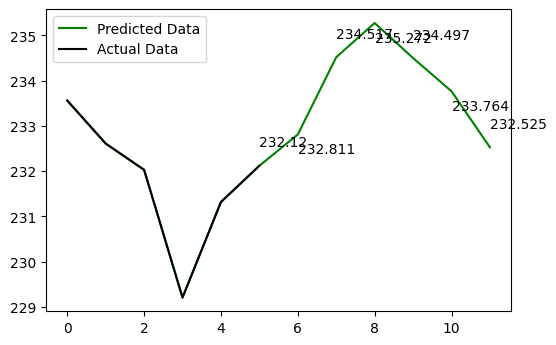

Training ended for V
10

Training started for NVDA
Epoch 1/7
1/1 - 0s - loss: 0.0108
Epoch 2/7
1/1 - 0s - loss: 0.0047
Epoch 3/7
1/1 - 0s - loss: 1.3905e-04
Epoch 4/7
1/1 - 0s - loss: 2.9976e-04
Epoch 5/7
1/1 - 0s - loss: 0.0121
Epoch 6/7
1/1 - 0s - loss: 2.2019e-04
Epoch 7/7
1/1 - 0s - loss: 0.0076
((1, 8, 1), (1, 1, 1), 'NVDA')


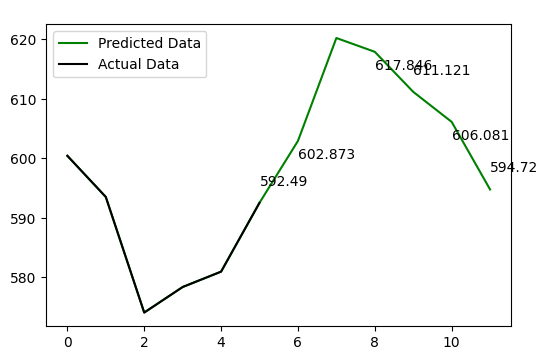

Training ended for NVDA
11

Training started for MA
Epoch 1/7
1/1 - 0s - loss: 0.2234
Epoch 2/7
1/1 - 0s - loss: 0.2236
Epoch 3/7
1/1 - 0s - loss: 0.2559
Epoch 4/7
1/1 - 0s - loss: 0.2625
Epoch 5/7
1/1 - 0s - loss: 0.2152
Epoch 6/7
1/1 - 0s - loss: 0.2084
Epoch 7/7
1/1 - 0s - loss: 0.2155
((1, 8, 1), (1, 1, 1), 'MA')


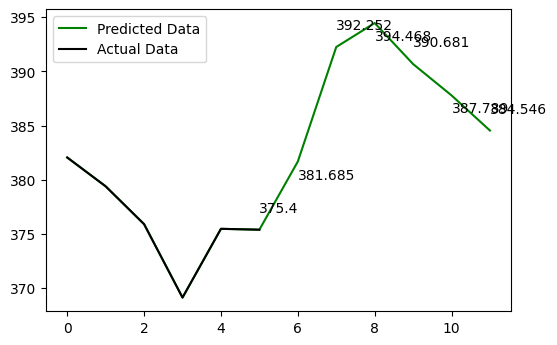

Training ended for MA
12

Training started for PYPL
Epoch 1/7
1/1 - 0s - loss: 0.1415
Epoch 2/7
1/1 - 0s - loss: 0.0791
Epoch 3/7
1/1 - 0s - loss: 0.1106
Epoch 4/7
1/1 - 0s - loss: 0.0724
Epoch 5/7
1/1 - 0s - loss: 0.1173
Epoch 6/7
1/1 - 0s - loss: 0.0832
Epoch 7/7
1/1 - 0s - loss: 0.0702
((1, 8, 1), (1, 1, 1), 'PYPL')


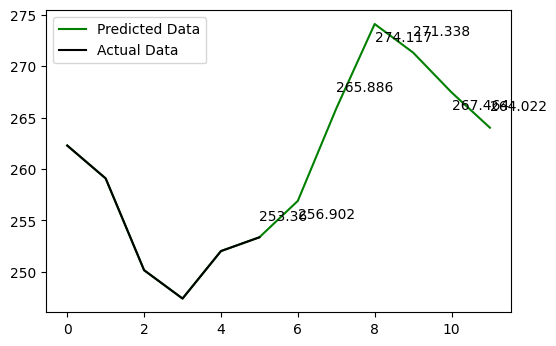

Training ended for PYPL
13

Training started for NFLX
Epoch 1/7
1/1 - 0s - loss: 0.0182
Epoch 2/7
1/1 - 0s - loss: 0.0639
Epoch 3/7
1/1 - 0s - loss: 0.0431
Epoch 4/7
1/1 - 0s - loss: 0.0483
Epoch 5/7
1/1 - 0s - loss: 0.0723
Epoch 6/7
1/1 - 0s - loss: 0.0384
Epoch 7/7
1/1 - 0s - loss: 0.0278
((1, 8, 1), (1, 1, 1), 'NFLX')


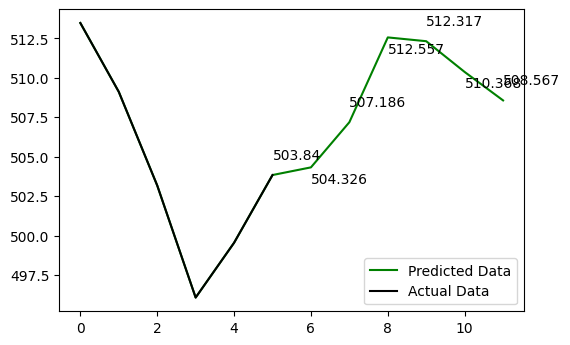

Training ended for NFLX
14

Training started for BRK-B
Epoch 1/7
1/1 - 0s - loss: 0.1070
Epoch 2/7
1/1 - 0s - loss: 0.0427
Epoch 3/7
1/1 - 0s - loss: 0.1291
Epoch 4/7
1/1 - 0s - loss: 0.0192
Epoch 5/7
1/1 - 0s - loss: 0.0419
Epoch 6/7
1/1 - 0s - loss: 0.0298
Epoch 7/7
1/1 - 0s - loss: 0.0416
((1, 8, 1), (1, 1, 1), 'BRK-B')


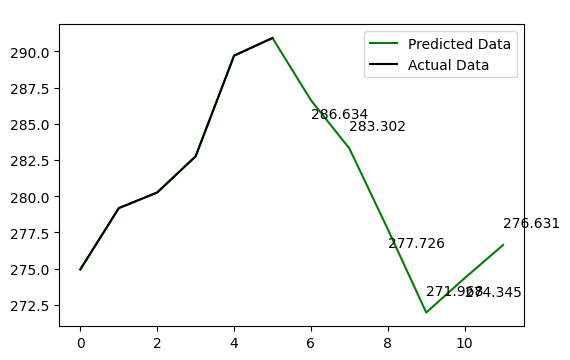

Training ended for BRK-B
15

Training started for JPM
Epoch 1/7
1/1 - 0s - loss: 0.0027
Epoch 2/7
1/1 - 0s - loss: 0.0090
Epoch 3/7
1/1 - 0s - loss: 0.0077
Epoch 4/7
1/1 - 0s - loss: 0.0038
Epoch 5/7
1/1 - 0s - loss: 4.5899e-04
Epoch 6/7
1/1 - 0s - loss: 0.0088
Epoch 7/7
1/1 - 0s - loss: 3.2479e-06
((1, 8, 1), (1, 1, 1), 'JPM')


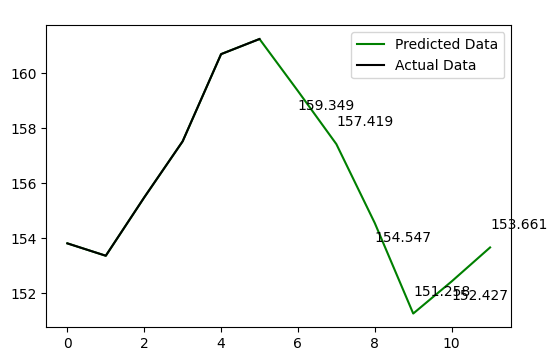

Training ended for JPM
16

Training started for BAC
Epoch 1/7
1/1 - 0s - loss: 0.0184
Epoch 2/7
1/1 - 0s - loss: 5.0393e-06
Epoch 3/7
1/1 - 0s - loss: 0.0069
Epoch 4/7
1/1 - 0s - loss: 0.0036
Epoch 5/7
1/1 - 0s - loss: 0.0085
Epoch 6/7
1/1 - 0s - loss: 0.0225
Epoch 7/7
1/1 - 0s - loss: 3.2473e-04
((1, 8, 1), (1, 1, 1), 'BAC')


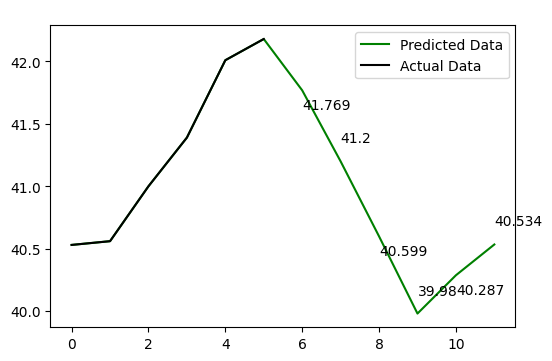

Training ended for BAC
17

Training started for WFC
Epoch 1/7
1/1 - 0s - loss: 0.1056
Epoch 2/7
1/1 - 0s - loss: 0.0263
Epoch 3/7
1/1 - 0s - loss: 0.0754
Epoch 4/7
1/1 - 0s - loss: 0.1048
Epoch 5/7
1/1 - 0s - loss: 0.0352
Epoch 6/7
1/1 - 0s - loss: 0.1180
Epoch 7/7
1/1 - 0s - loss: 0.0478
((1, 8, 1), (1, 1, 1), 'WFC')


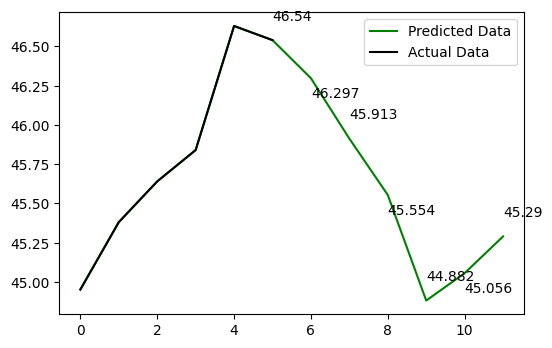

Training ended for WFC
18

Training started for MS
Epoch 1/7
1/1 - 0s - loss: 0.0306
Epoch 2/7
1/1 - 0s - loss: 0.0403
Epoch 3/7
1/1 - 0s - loss: 0.0956
Epoch 4/7
1/1 - 0s - loss: 0.0818
Epoch 5/7
1/1 - 0s - loss: 0.0841
Epoch 6/7
1/1 - 0s - loss: 0.0692
Epoch 7/7
1/1 - 0s - loss: 0.1022
((1, 8, 1), (1, 1, 1), 'MS')


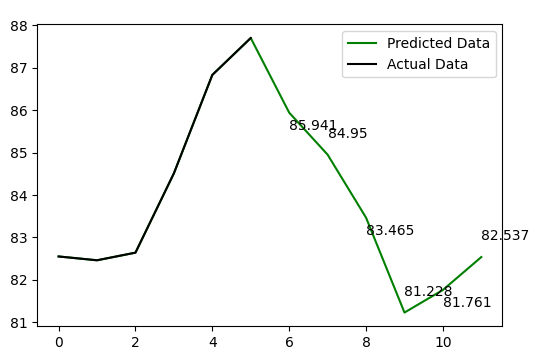

Training ended for MS
19

Training started for C
Epoch 1/7
1/1 - 0s - loss: 0.0083
Epoch 2/7
1/1 - 0s - loss: 0.0039
Epoch 3/7
1/1 - 0s - loss: 0.0047
Epoch 4/7
1/1 - 0s - loss: 0.0010
Epoch 5/7
1/1 - 0s - loss: 0.0033
Epoch 6/7
1/1 - 0s - loss: 5.5507e-04
Epoch 7/7
1/1 - 0s - loss: 0.0017
((1, 8, 1), (1, 1, 1), 'C')


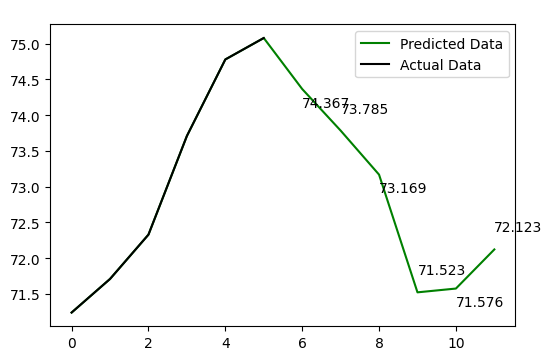

Training ended for C
20

Training started for BLK
Epoch 1/7
1/1 - 0s - loss: 0.0352
Epoch 2/7
1/1 - 0s - loss: 0.0165
Epoch 3/7
1/1 - 0s - loss: 0.0172
Epoch 4/7
1/1 - 0s - loss: 0.0509
Epoch 5/7
1/1 - 0s - loss: 0.0051
Epoch 6/7
1/1 - 0s - loss: 0.0255
Epoch 7/7
1/1 - 0s - loss: 0.0114
((1, 8, 1), (1, 1, 1), 'BLK')


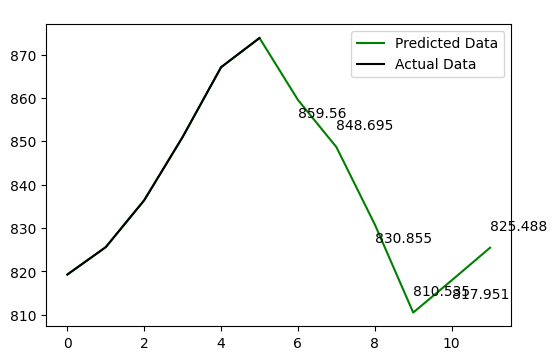

Training ended for BLK
21

Training started for AMT
Epoch 1/7
1/1 - 0s - loss: 3.8513e-05
Epoch 2/7
1/1 - 0s - loss: 0.0029
Epoch 3/7
1/1 - 0s - loss: 0.0389
Epoch 4/7
1/1 - 0s - loss: 0.0154
Epoch 5/7
1/1 - 0s - loss: 0.0228
Epoch 6/7
1/1 - 0s - loss: 3.0088e-05
Epoch 7/7
1/1 - 0s - loss: 0.0052
((1, 8, 1), (1, 1, 1), 'AMT')


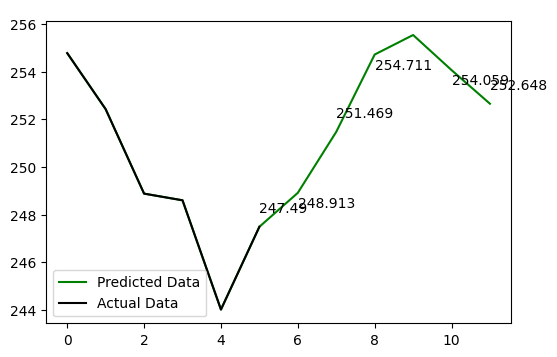

Training ended for AMT
22

Training started for PLD
Epoch 1/7
1/1 - 0s - loss: 0.9264
Epoch 2/7
1/1 - 0s - loss: 0.8565
Epoch 3/7
1/1 - 0s - loss: 1.0342
Epoch 4/7
1/1 - 0s - loss: 0.7389
Epoch 5/7
1/1 - 0s - loss: 0.7171
Epoch 6/7
1/1 - 0s - loss: 0.5660
Epoch 7/7
1/1 - 0s - loss: 0.6348
((1, 8, 1), (1, 1, 1), 'PLD')


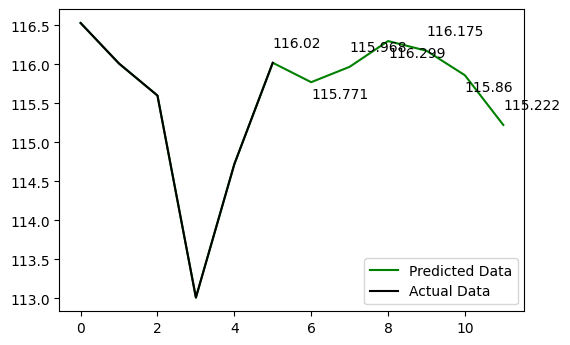

Training ended for PLD
23

Training started for CCI
Epoch 1/7
1/1 - 0s - loss: 0.0251
Epoch 2/7
1/1 - 0s - loss: 0.0357
Epoch 3/7
1/1 - 0s - loss: 0.0170
Epoch 4/7
1/1 - 0s - loss: 0.0140
Epoch 5/7
1/1 - 0s - loss: 0.0213
Epoch 6/7
1/1 - 0s - loss: 0.0163
Epoch 7/7
1/1 - 0s - loss: 0.0346
((1, 8, 1), (1, 1, 1), 'CCI')


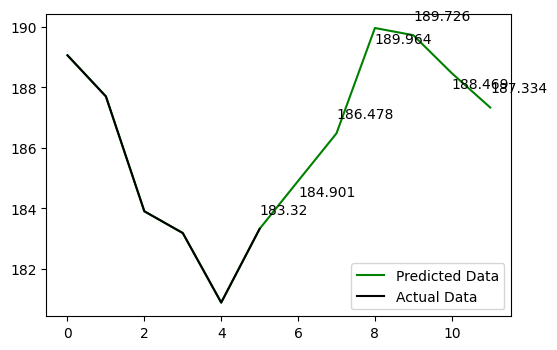

Training ended for CCI
24

Training started for EQIX
Epoch 1/7
1/1 - 0s - loss: 0.3950
Epoch 2/7
1/1 - 0s - loss: 0.4657
Epoch 3/7
1/1 - 0s - loss: 0.3877
Epoch 4/7
1/1 - 0s - loss: 0.3512
Epoch 5/7
1/1 - 0s - loss: 0.1095
Epoch 6/7
1/1 - 0s - loss: 0.0763
Epoch 7/7
1/1 - 0s - loss: 0.1016
((1, 8, 1), (1, 1, 1), 'EQIX')


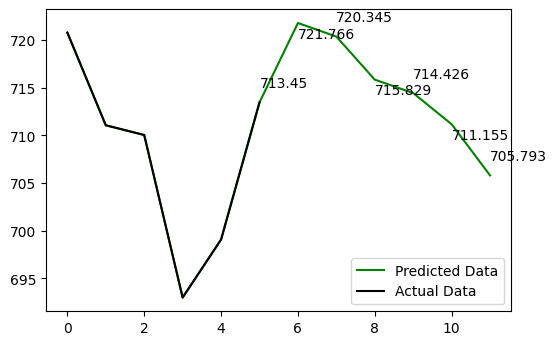

Training ended for EQIX
25

Training started for SPG
Epoch 1/7
1/1 - 0s - loss: 0.0017
Epoch 2/7
1/1 - 0s - loss: 0.0060
Epoch 3/7
1/1 - 0s - loss: 0.0061
Epoch 4/7
1/1 - 0s - loss: 0.0143
Epoch 5/7
1/1 - 0s - loss: 0.0070
Epoch 6/7
1/1 - 0s - loss: 0.0159
Epoch 7/7
1/1 - 0s - loss: 8.5164e-04
((1, 8, 1), (1, 1, 1), 'SPG')


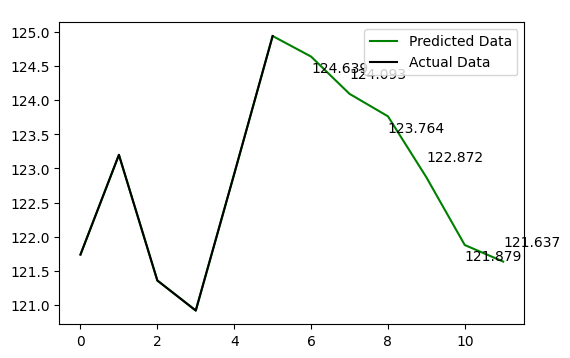

Training ended for SPG
26

Training started for PSA
Epoch 1/7
1/1 - 0s - loss: 0.0989
Epoch 2/7
1/1 - 0s - loss: 0.0209
Epoch 3/7
1/1 - 0s - loss: 0.2795
Epoch 4/7
1/1 - 0s - loss: 0.1112
Epoch 5/7
1/1 - 0s - loss: 0.0858
Epoch 6/7
1/1 - 0s - loss: 0.1013
Epoch 7/7
1/1 - 0s - loss: 0.0718
((1, 8, 1), (1, 1, 1), 'PSA')


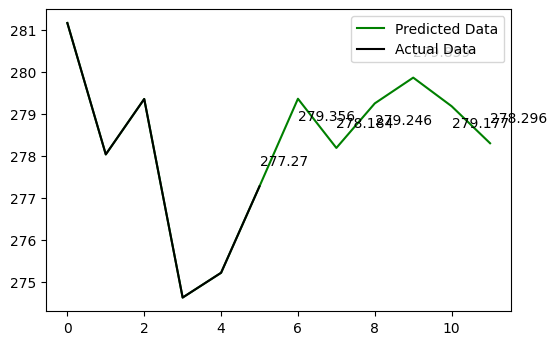

Training ended for PSA
27

Training started for WELL
Epoch 1/7
1/1 - 0s - loss: 0.1634
Epoch 2/7
1/1 - 0s - loss: 0.2720
Epoch 3/7
1/1 - 0s - loss: 0.1181
Epoch 4/7
1/1 - 0s - loss: 0.2187
Epoch 5/7
1/1 - 0s - loss: 0.1768
Epoch 6/7
1/1 - 0s - loss: 0.1702
Epoch 7/7
1/1 - 0s - loss: 0.1243
((1, 8, 1), (1, 1, 1), 'WELL')


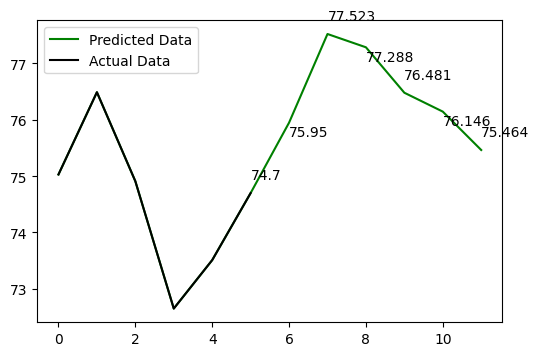

Training ended for WELL
28

Training started for EQR
Epoch 1/7
1/1 - 0s - loss: 0.0379
Epoch 2/7
1/1 - 0s - loss: 2.0639e-04
Epoch 3/7
1/1 - 0s - loss: 0.0078
Epoch 4/7
1/1 - 0s - loss: 0.0186
Epoch 5/7
1/1 - 0s - loss: 0.0038
Epoch 6/7
1/1 - 0s - loss: 0.0149
Epoch 7/7
1/1 - 0s - loss: 0.0132
((1, 8, 1), (1, 1, 1), 'EQR')


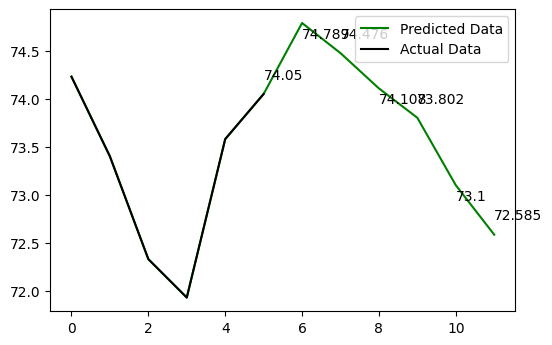

Training ended for EQR
29

Training started for AVB
Epoch 1/7
1/1 - 0s - loss: 0.0237
Epoch 2/7
1/1 - 0s - loss: 0.0346
Epoch 3/7
1/1 - 0s - loss: 0.0035
Epoch 4/7
1/1 - 0s - loss: 0.0046
Epoch 5/7
1/1 - 0s - loss: 0.0112
Epoch 6/7
1/1 - 0s - loss: 0.0120
Epoch 7/7
1/1 - 0s - loss: 0.0123
((1, 8, 1), (1, 1, 1), 'AVB')


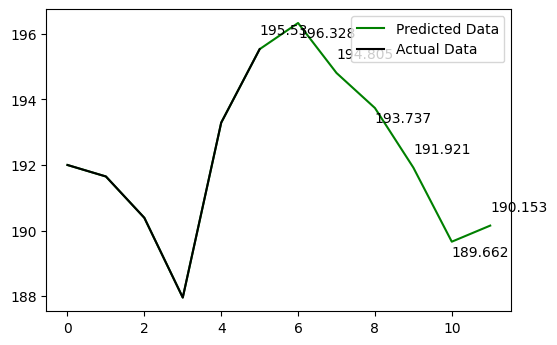

Training ended for AVB
30

Training started for SBAC
Epoch 1/7
1/1 - 0s - loss: 0.4692
Epoch 2/7
1/1 - 0s - loss: 0.6920
Epoch 3/7
1/1 - 0s - loss: 0.6337
Epoch 4/7
1/1 - 0s - loss: 0.4821
Epoch 5/7
1/1 - 0s - loss: 0.2319
Epoch 6/7
1/1 - 0s - loss: 0.2094
Epoch 7/7
1/1 - 0s - loss: 0.1576
((1, 8, 1), (1, 1, 1), 'SBAC')


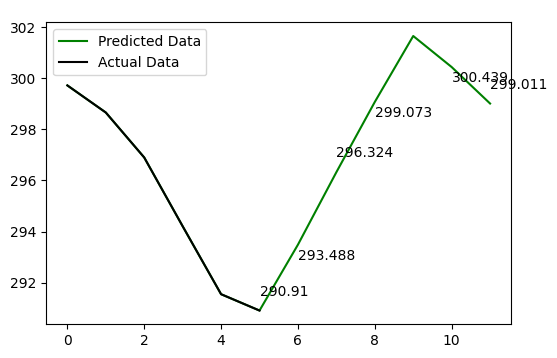

Training ended for SBAC
31

Training started for XOM
Epoch 1/7
1/1 - 0s - loss: 0.0152
Epoch 2/7
1/1 - 0s - loss: 0.0643
Epoch 3/7
1/1 - 0s - loss: 0.0375
Epoch 4/7
1/1 - 0s - loss: 0.0125
Epoch 5/7
1/1 - 0s - loss: 0.0211
Epoch 6/7
1/1 - 0s - loss: 7.0751e-04
Epoch 7/7
1/1 - 0s - loss: 0.0055
((1, 8, 1), (1, 1, 1), 'XOM')


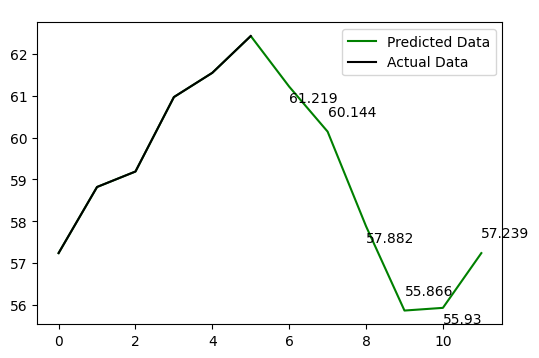

Training ended for XOM
32

Training started for CVX
Epoch 1/7
1/1 - 0s - loss: 0.0068
Epoch 2/7
1/1 - 0s - loss: 1.4022e-04
Epoch 3/7
1/1 - 0s - loss: 0.0157
Epoch 4/7
1/1 - 0s - loss: 4.1753e-04
Epoch 5/7
1/1 - 0s - loss: 0.0032
Epoch 6/7
1/1 - 0s - loss: 0.0716
Epoch 7/7
1/1 - 0s - loss: 0.0025
((1, 8, 1), (1, 1, 1), 'CVX')


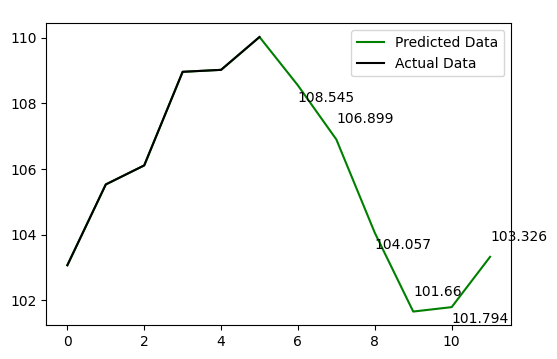

Training ended for CVX
33

Training started for NEP
Epoch 1/7
1/1 - 0s - loss: 0.0653
Epoch 2/7
1/1 - 0s - loss: 0.0028
Epoch 3/7
1/1 - 0s - loss: 0.0088
Epoch 4/7
1/1 - 0s - loss: 0.0133
Epoch 5/7
1/1 - 0s - loss: 0.0330
Epoch 6/7
1/1 - 0s - loss: 0.0037
Epoch 7/7
1/1 - 0s - loss: 0.0047
((1, 8, 1), (1, 1, 1), 'NEP')


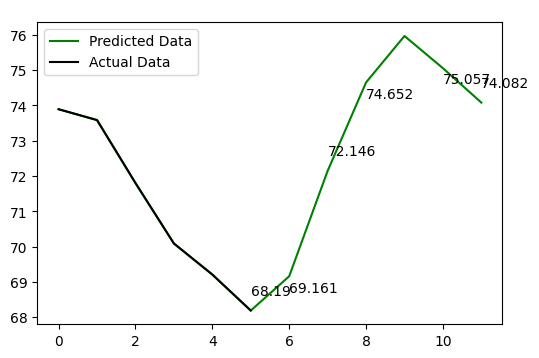

Training ended for NEP
34

Training started for SO
Epoch 1/7
1/1 - 0s - loss: 0.2040
Epoch 2/7
1/1 - 0s - loss: 0.0863
Epoch 3/7
1/1 - 0s - loss: 0.2106
Epoch 4/7
1/1 - 0s - loss: 0.3960
Epoch 5/7
1/1 - 0s - loss: 0.2656
Epoch 6/7
1/1 - 0s - loss: 0.0060
Epoch 7/7
1/1 - 0s - loss: 0.0065
((1, 8, 1), (1, 1, 1), 'SO')


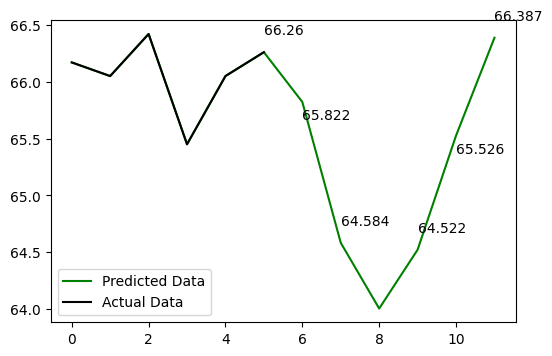

Training ended for SO
35

Training started for D
Epoch 1/7
1/1 - 0s - loss: 0.0245
Epoch 2/7
1/1 - 0s - loss: 0.0236
Epoch 3/7
1/1 - 0s - loss: 0.0207
Epoch 4/7
1/1 - 0s - loss: 9.8215e-06
Epoch 5/7
1/1 - 0s - loss: 0.1238
Epoch 6/7
1/1 - 0s - loss: 0.0371
Epoch 7/7
1/1 - 0s - loss: 0.0028
((1, 8, 1), (1, 1, 1), 'D')


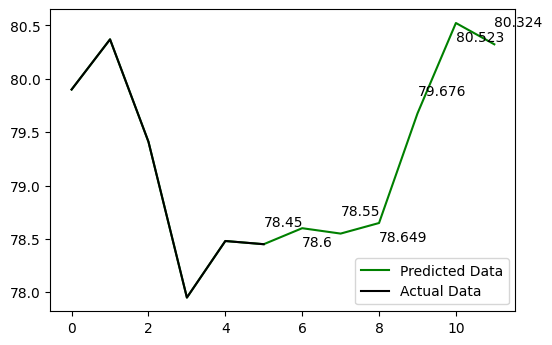

Training ended for D
36

Training started for DUK
Epoch 1/7
1/1 - 0s - loss: 0.0136
Epoch 2/7
1/1 - 0s - loss: 0.1714
Epoch 3/7
1/1 - 0s - loss: 0.0586
Epoch 4/7
1/1 - 0s - loss: 0.0828
Epoch 5/7
1/1 - 0s - loss: 1.5019e-04
Epoch 6/7
1/1 - 0s - loss: 0.0013
Epoch 7/7
1/1 - 0s - loss: 0.0120
((1, 8, 1), (1, 1, 1), 'DUK')


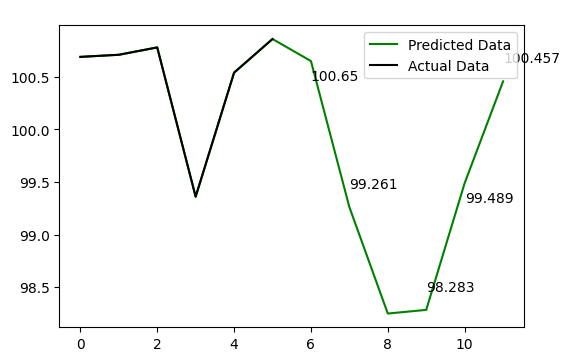

Training ended for DUK
37

Training started for COP
Epoch 1/7
1/1 - 0s - loss: 0.0019
Epoch 2/7
1/1 - 0s - loss: 0.0036
Epoch 3/7
1/1 - 0s - loss: 0.0015
Epoch 4/7
1/1 - 0s - loss: 0.0018
Epoch 5/7
1/1 - 0s - loss: 1.6543e-04
Epoch 6/7
1/1 - 0s - loss: 0.0021
Epoch 7/7
1/1 - 0s - loss: 1.2081e-04
((1, 8, 1), (1, 1, 1), 'COP')


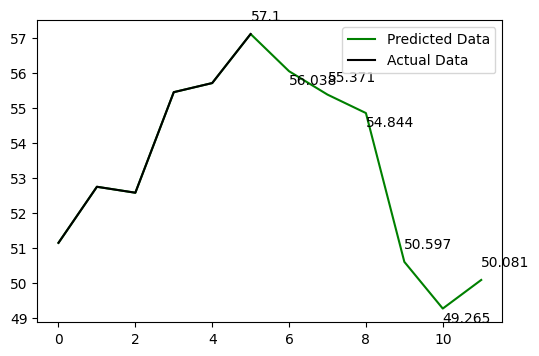

Training ended for COP
38

Training started for AEP
Epoch 1/7
1/1 - 0s - loss: 0.0038
Epoch 2/7
1/1 - 0s - loss: 0.0095
Epoch 3/7
1/1 - 0s - loss: 0.1371
Epoch 4/7
1/1 - 0s - loss: 0.0018
Epoch 5/7
1/1 - 0s - loss: 1.1412e-06
Epoch 6/7
1/1 - 0s - loss: 0.0478
Epoch 7/7
1/1 - 0s - loss: 4.7802e-04
((1, 8, 1), (1, 1, 1), 'AEP')


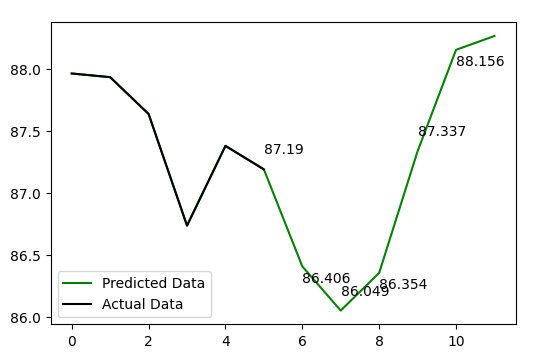

Training ended for AEP
39

Training started for KMI
Epoch 1/7
1/1 - 0s - loss: 0.0045
Epoch 2/7
1/1 - 0s - loss: 4.3828e-04
Epoch 3/7
1/1 - 0s - loss: 2.9759e-05
Epoch 4/7
1/1 - 0s - loss: 6.8981e-06
Epoch 5/7
1/1 - 0s - loss: 4.0825e-04
Epoch 6/7
1/1 - 0s - loss: 0.0096
Epoch 7/7
1/1 - 0s - loss: 3.7356e-04
((1, 8, 1), (1, 1, 1), 'KMI')


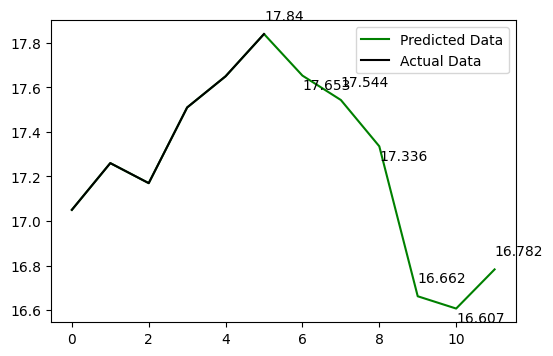

Training ended for KMI
40

Training started for EXC
Epoch 1/7
1/1 - 0s - loss: 2.3895e-04
Epoch 2/7
1/1 - 0s - loss: 3.8199e-05
Epoch 3/7
1/1 - 0s - loss: 0.0013
Epoch 4/7
1/1 - 0s - loss: 7.8342e-04
Epoch 5/7
1/1 - 0s - loss: 0.0071
Epoch 6/7
1/1 - 0s - loss: 0.0148
Epoch 7/7
1/1 - 0s - loss: 0.0017
((1, 8, 1), (1, 1, 1), 'EXC')


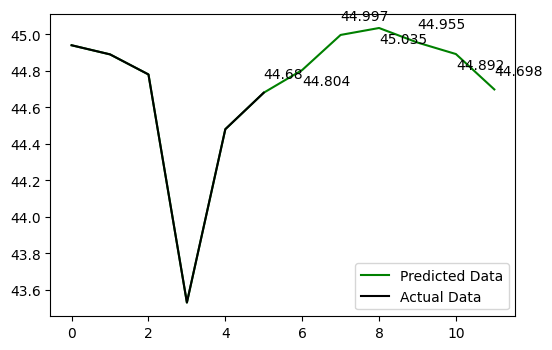

Training ended for EXC
41

Training started for CVS
Epoch 1/7
1/1 - 0s - loss: 0.0492
Epoch 2/7
1/1 - 0s - loss: 0.0046
Epoch 3/7
1/1 - 0s - loss: 0.0055
Epoch 4/7
1/1 - 0s - loss: 0.0177
Epoch 5/7
1/1 - 0s - loss: 1.1614e-04
Epoch 6/7
1/1 - 0s - loss: 0.0019
Epoch 7/7
1/1 - 0s - loss: 0.0377
((1, 8, 1), (1, 1, 1), 'CVS')


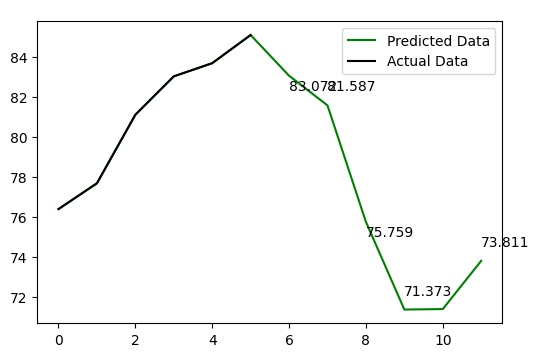

Training ended for CVS
42

Training started for UNH
Epoch 1/7
1/1 - 0s - loss: 0.0015
Epoch 2/7
1/1 - 0s - loss: 0.0026
Epoch 3/7
1/1 - 0s - loss: 0.0099
Epoch 4/7
1/1 - 0s - loss: 0.0086
Epoch 5/7
1/1 - 0s - loss: 0.0362
Epoch 6/7
1/1 - 0s - loss: 9.0139e-04
Epoch 7/7
1/1 - 0s - loss: 0.0010
((1, 8, 1), (1, 1, 1), 'UNH')


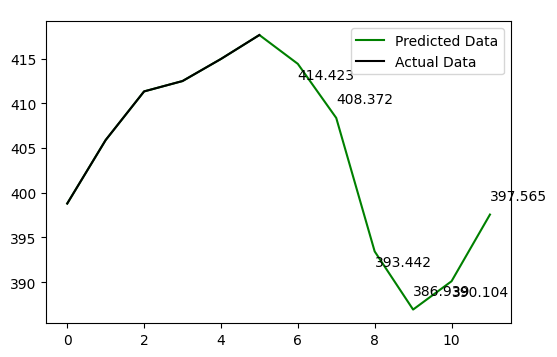

Training ended for UNH
43

Training started for MCK
Epoch 1/7
1/1 - 0s - loss: 4.0529
Epoch 2/7
1/1 - 0s - loss: 2.7804
Epoch 3/7
1/1 - 0s - loss: 1.9055
Epoch 4/7
1/1 - 0s - loss: 1.6276
Epoch 5/7
1/1 - 0s - loss: 1.1748
Epoch 6/7
1/1 - 0s - loss: 0.6939
Epoch 7/7
1/1 - 0s - loss: 0.5294
((1, 8, 1), (1, 1, 1), 'MCK')


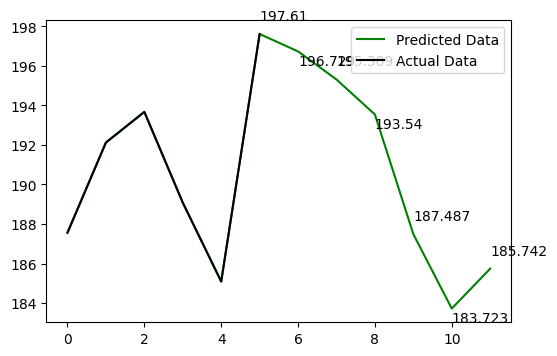

Training ended for MCK
44

Training started for ABC
Epoch 1/7
1/1 - 0s - loss: 0.2466
Epoch 2/7
1/1 - 0s - loss: 0.2028
Epoch 3/7
1/1 - 0s - loss: 0.6000
Epoch 4/7
1/1 - 0s - loss: 0.8601
Epoch 5/7
1/1 - 0s - loss: 0.5752
Epoch 6/7
1/1 - 0s - loss: 0.7129
Epoch 7/7
1/1 - 0s - loss: 0.8830
((1, 8, 1), (1, 1, 1), 'ABC')


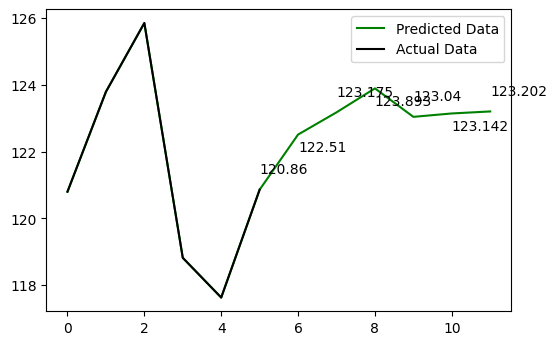

Training ended for ABC
45

Training started for CI
Epoch 1/7
1/1 - 0s - loss: 0.1706
Epoch 2/7
1/1 - 0s - loss: 0.1608
Epoch 3/7
1/1 - 0s - loss: 0.0473
Epoch 4/7
1/1 - 0s - loss: 0.0143
Epoch 5/7
1/1 - 0s - loss: 0.0298
Epoch 6/7
1/1 - 0s - loss: 0.0172
Epoch 7/7
1/1 - 0s - loss: 0.0136
((1, 8, 1), (1, 1, 1), 'CI')


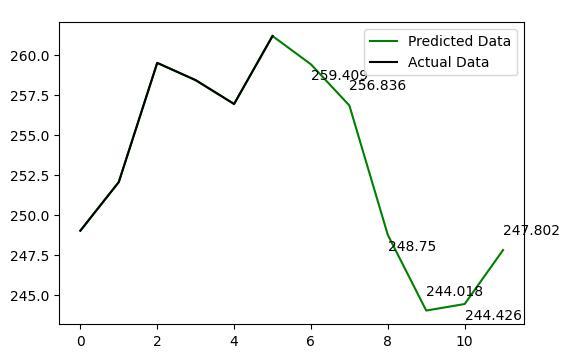

Training ended for CI
46

Training started for CAH
Epoch 1/7
1/1 - 0s - loss: 0.4187
Epoch 2/7
1/1 - 0s - loss: 0.4216
Epoch 3/7
1/1 - 0s - loss: 0.4804
Epoch 4/7
1/1 - 0s - loss: 0.2297
Epoch 5/7
1/1 - 0s - loss: 0.2929
Epoch 6/7
1/1 - 0s - loss: 0.2368
Epoch 7/7
1/1 - 0s - loss: 0.1587
((1, 8, 1), (1, 1, 1), 'CAH')


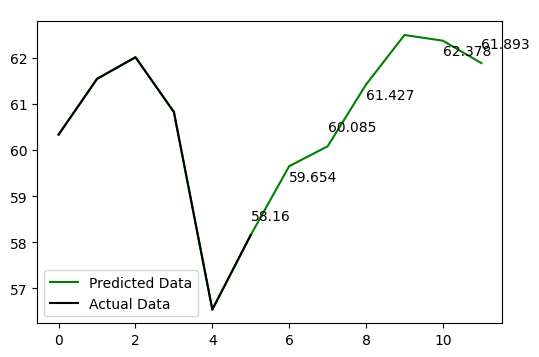

Training ended for CAH
47

Training started for ANTM
Epoch 1/7
1/1 - 0s - loss: 0.0513
Epoch 2/7
1/1 - 0s - loss: 0.1173
Epoch 3/7
1/1 - 0s - loss: 0.0647
Epoch 4/7
1/1 - 0s - loss: 0.0648
Epoch 5/7
1/1 - 0s - loss: 0.0670
Epoch 6/7
1/1 - 0s - loss: 0.0562
Epoch 7/7
1/1 - 0s - loss: 0.0176
((1, 8, 1), (1, 1, 1), 'ANTM')


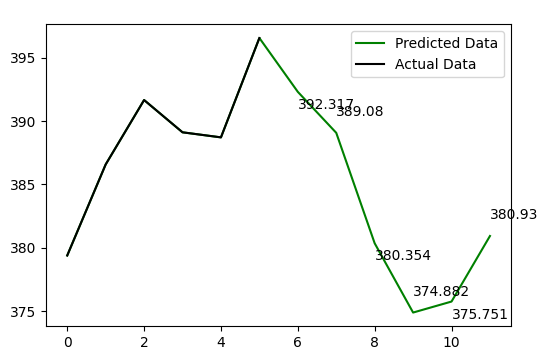

Training ended for ANTM
48

Training started for JNJ
Epoch 1/7
1/1 - 0s - loss: 1.1040e-04
Epoch 2/7
1/1 - 0s - loss: 0.0093
Epoch 3/7
1/1 - 0s - loss: 0.0124
Epoch 4/7
1/1 - 0s - loss: 0.0807
Epoch 5/7
1/1 - 0s - loss: 0.0058
Epoch 6/7
1/1 - 0s - loss: 0.0603
Epoch 7/7
1/1 - 0s - loss: 0.0724
((1, 8, 1), (1, 1, 1), 'JNJ')


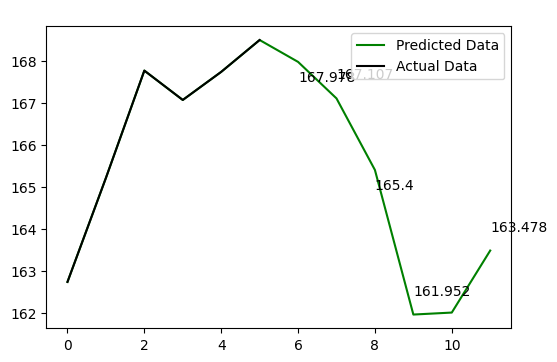

Training ended for JNJ
49

Training started for CNC
Epoch 1/7
1/1 - 0s - loss: 0.0546
Epoch 2/7
1/1 - 0s - loss: 0.1208
Epoch 3/7
1/1 - 0s - loss: 0.0688
Epoch 4/7
1/1 - 0s - loss: 0.0546
Epoch 5/7
1/1 - 0s - loss: 0.0922
Epoch 6/7
1/1 - 0s - loss: 0.0831
Epoch 7/7
1/1 - 0s - loss: 0.0309
((1, 8, 1), (1, 1, 1), 'CNC')


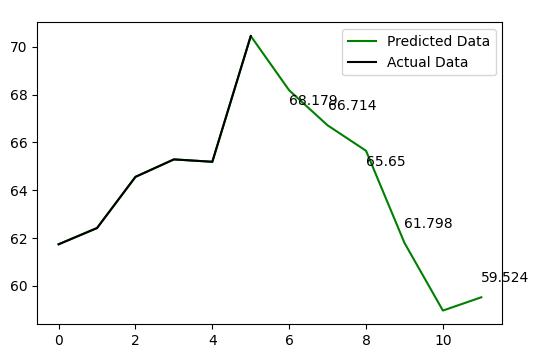

Training ended for CNC
50

Training started for HUM
Epoch 1/7
1/1 - 0s - loss: 0.2006
Epoch 2/7
1/1 - 0s - loss: 0.1396
Epoch 3/7
1/1 - 0s - loss: 0.1691
Epoch 4/7
1/1 - 0s - loss: 0.1754
Epoch 5/7
1/1 - 0s - loss: 0.2362
Epoch 6/7
1/1 - 0s - loss: 0.1459
Epoch 7/7
1/1 - 0s - loss: 0.1483
((1, 8, 1), (1, 1, 1), 'HUM')


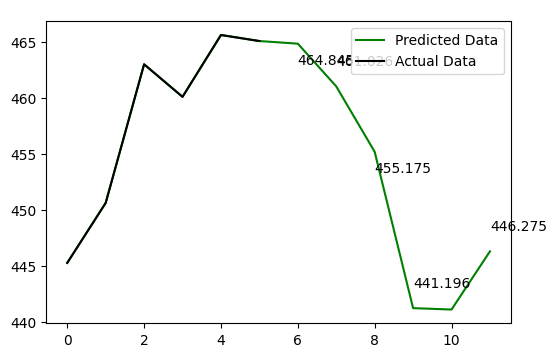

Training ended for HUM
51

Training started for THO
Epoch 1/7
1/1 - 0s - loss: 0.2823
Epoch 2/7
1/1 - 0s - loss: 0.2401
Epoch 3/7
1/1 - 0s - loss: 0.2609
Epoch 4/7
1/1 - 0s - loss: 0.1633
Epoch 5/7
1/1 - 0s - loss: 0.2218
Epoch 6/7
1/1 - 0s - loss: 0.1531
Epoch 7/7
1/1 - 0s - loss: 0.1796
((1, 8, 1), (1, 1, 1), 'THO')


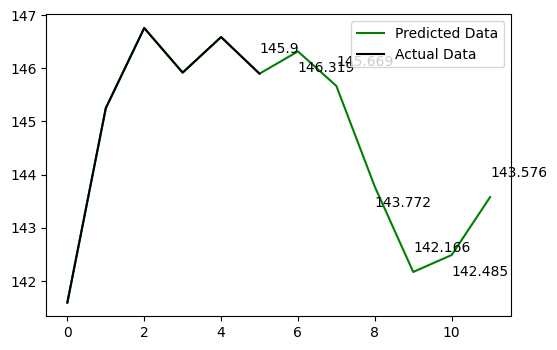

Training ended for THO
52

Training started for ALGN
Epoch 1/7
1/1 - 0s - loss: 0.1019
Epoch 2/7
1/1 - 0s - loss: 0.1355
Epoch 3/7
1/1 - 0s - loss: 0.1110
Epoch 4/7
1/1 - 0s - loss: 0.1033
Epoch 5/7
1/1 - 0s - loss: 0.0914
Epoch 6/7
1/1 - 0s - loss: 0.1557
Epoch 7/7
1/1 - 0s - loss: 0.0665
((1, 8, 1), (1, 1, 1), 'ALGN')


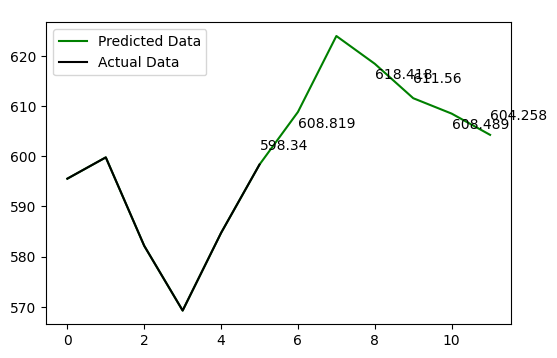

Training ended for ALGN
53

Training started for PATK
Epoch 1/7
1/1 - 0s - loss: 0.1330
Epoch 2/7
1/1 - 0s - loss: 0.1611
Epoch 3/7
1/1 - 0s - loss: 0.1126
Epoch 4/7
1/1 - 0s - loss: 0.0630
Epoch 5/7
1/1 - 0s - loss: 0.0746
Epoch 6/7
1/1 - 0s - loss: 0.0642
Epoch 7/7
1/1 - 0s - loss: 0.0074
((1, 8, 1), (1, 1, 1), 'PATK')


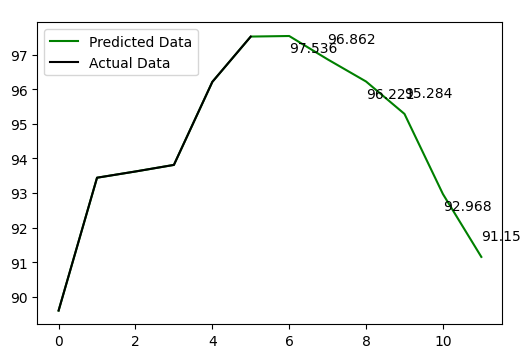

Training ended for PATK
54

Training started for LCII
Epoch 1/7
1/1 - 0s - loss: 0.2111
Epoch 2/7
1/1 - 0s - loss: 0.2207
Epoch 3/7
1/1 - 0s - loss: 0.2050
Epoch 4/7
1/1 - 0s - loss: 0.1928
Epoch 5/7
1/1 - 0s - loss: 0.1608
Epoch 6/7
1/1 - 0s - loss: 0.1130
Epoch 7/7
1/1 - 0s - loss: 0.1277
((1, 8, 1), (1, 1, 1), 'LCII')


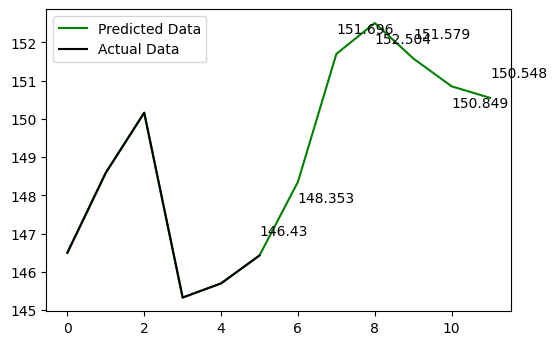

Training ended for LCII
55

Training started for SHW
Epoch 1/7
1/1 - 0s - loss: 0.0833
Epoch 2/7
1/1 - 0s - loss: 0.0929
Epoch 3/7
1/1 - 0s - loss: 0.0996
Epoch 4/7
1/1 - 0s - loss: 0.1061
Epoch 5/7
1/1 - 0s - loss: 0.1124
Epoch 6/7
1/1 - 0s - loss: 0.1149
Epoch 7/7
1/1 - 0s - loss: 0.0988
((1, 8, 1), (1, 1, 1), 'SHW')


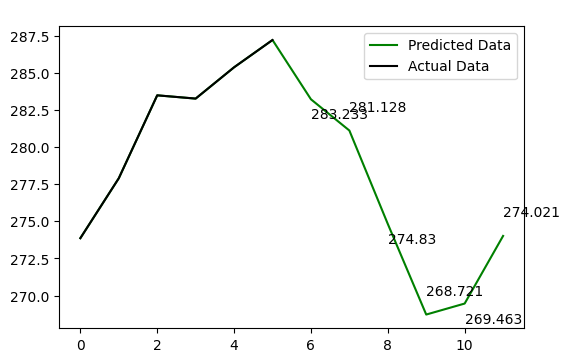

Training ended for SHW
56

Training started for SAFM
Epoch 1/7
1/1 - 0s - loss: 0.0660
Epoch 2/7
1/1 - 0s - loss: 0.0191
Epoch 3/7
1/1 - 0s - loss: 0.0635
Epoch 4/7
1/1 - 0s - loss: 0.0471
Epoch 5/7
1/1 - 0s - loss: 0.0389
Epoch 6/7
1/1 - 0s - loss: 0.0229
Epoch 7/7
1/1 - 0s - loss: 0.0125
((1, 8, 1), (1, 1, 1), 'SAFM')


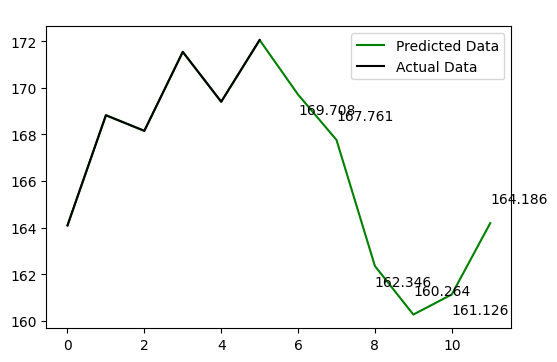

Training ended for SAFM
57

Training started for LEA
Epoch 1/7
1/1 - 0s - loss: 0.1194
Epoch 2/7
1/1 - 0s - loss: 0.0370
Epoch 3/7
1/1 - 0s - loss: 0.0667
Epoch 4/7
1/1 - 0s - loss: 0.0248
Epoch 5/7
1/1 - 0s - loss: 0.0020
Epoch 6/7
1/1 - 0s - loss: 0.0016
Epoch 7/7
1/1 - 0s - loss: 7.4792e-04
((1, 8, 1), (1, 1, 1), 'LEA')


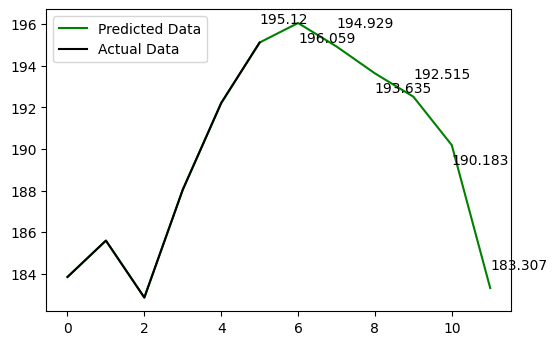

Training ended for LEA
58

Training started for CLX
Epoch 1/7
1/1 - 0s - loss: 2.3165
Epoch 2/7
1/1 - 0s - loss: 2.4017
Epoch 3/7
1/1 - 0s - loss: 2.0772
Epoch 4/7
1/1 - 0s - loss: 1.4992
Epoch 5/7
1/1 - 0s - loss: 1.8194
Epoch 6/7
1/1 - 0s - loss: 1.3102
Epoch 7/7
1/1 - 0s - loss: 1.4287
((1, 8, 1), (1, 1, 1), 'CLX')


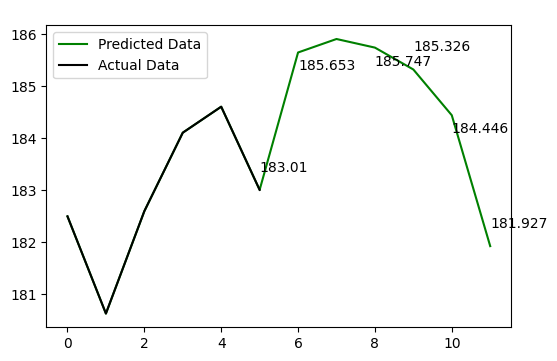

Training ended for CLX
59

Training started for LANC
Epoch 1/7
1/1 - 0s - loss: 0.0068
Epoch 2/7
1/1 - 0s - loss: 0.0027
Epoch 3/7
1/1 - 0s - loss: 0.0083
Epoch 4/7
1/1 - 0s - loss: 0.0012
Epoch 5/7
1/1 - 0s - loss: 0.0017
Epoch 6/7
1/1 - 0s - loss: 6.0457e-05
Epoch 7/7
1/1 - 0s - loss: 0.0012
((1, 8, 1), (1, 1, 1), 'LANC')


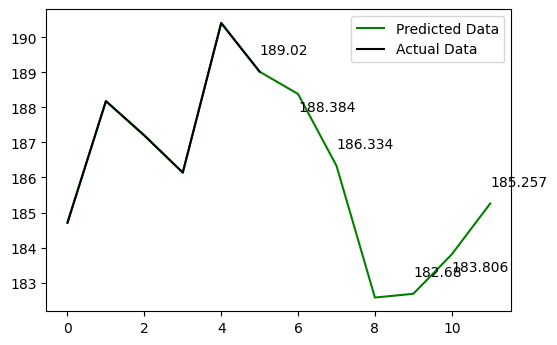

Training ended for LANC
60

Training started for DIS
Epoch 1/7
1/1 - 0s - loss: 2.3529
Epoch 2/7
1/1 - 0s - loss: 1.3639
Epoch 3/7
1/1 - 0s - loss: 1.8805
Epoch 4/7
1/1 - 0s - loss: 1.0446
Epoch 5/7
1/1 - 0s - loss: 1.0593
Epoch 6/7
1/1 - 0s - loss: 0.9102
Epoch 7/7
1/1 - 0s - loss: 0.8801
((1, 8, 1), (1, 1, 1), 'DIS')


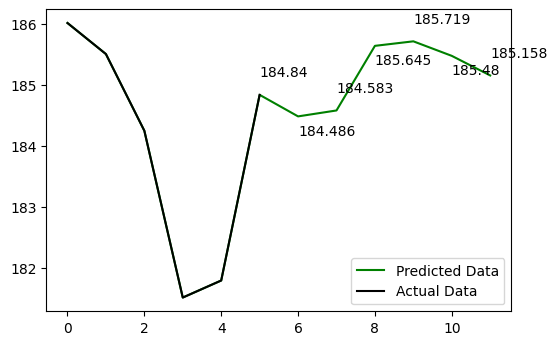

Training ended for DIS
61

Training started for CMCSA
Epoch 1/7
1/1 - 0s - loss: 0.1524
Epoch 2/7
1/1 - 0s - loss: 0.1634
Epoch 3/7
1/1 - 0s - loss: 0.1307
Epoch 4/7
1/1 - 0s - loss: 0.1262
Epoch 5/7
1/1 - 0s - loss: 0.1589
Epoch 6/7
1/1 - 0s - loss: 0.0840
Epoch 7/7
1/1 - 0s - loss: 0.1091
((1, 8, 1), (1, 1, 1), 'CMCSA')


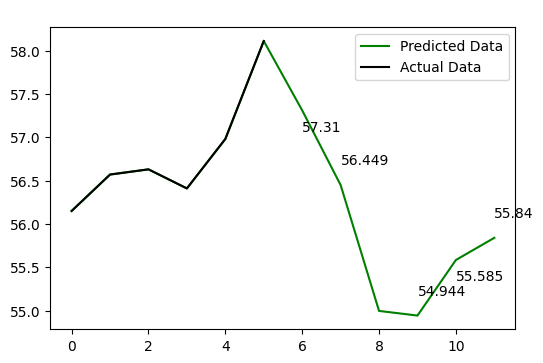

Training ended for CMCSA
62

Training started for NKE
Epoch 1/7
1/1 - 0s - loss: 1.1143
Epoch 2/7
1/1 - 0s - loss: 1.0743
Epoch 3/7
1/1 - 0s - loss: 1.0908
Epoch 4/7
1/1 - 0s - loss: 0.8974
Epoch 5/7
1/1 - 0s - loss: 0.8190
Epoch 6/7
1/1 - 0s - loss: 0.6159
Epoch 7/7
1/1 - 0s - loss: 0.5844
((1, 8, 1), (1, 1, 1), 'NKE')


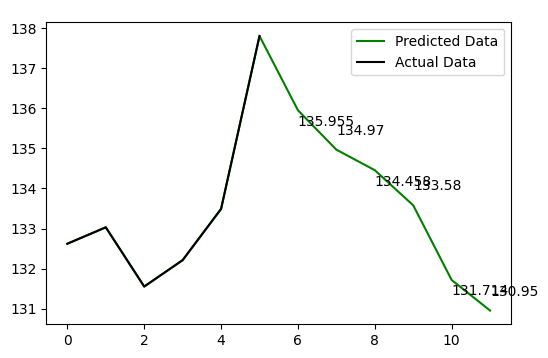

Training ended for NKE
63

Training started for CHTR
Epoch 1/7
1/1 - 0s - loss: 3.3177e-05
Epoch 2/7
1/1 - 0s - loss: 7.0830e-05
Epoch 3/7
1/1 - 0s - loss: 0.0169
Epoch 4/7
1/1 - 0s - loss: 0.0141
Epoch 5/7
1/1 - 0s - loss: 0.0443
Epoch 6/7
1/1 - 0s - loss: 0.0339
Epoch 7/7
1/1 - 0s - loss: 0.0223
((1, 8, 1), (1, 1, 1), 'CHTR')


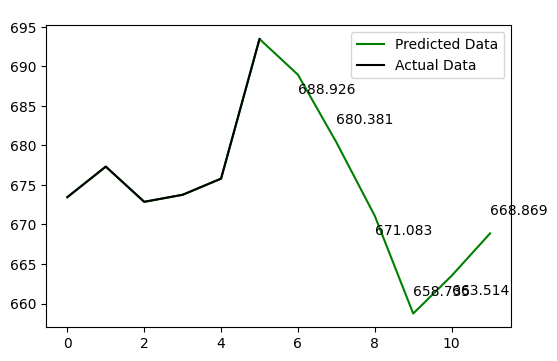

Training ended for CHTR
64

Training started for ATVI
Epoch 1/7
1/1 - 0s - loss: 0.0011
Epoch 2/7
1/1 - 0s - loss: 9.2400e-04
Epoch 3/7
1/1 - 0s - loss: 0.0252
Epoch 4/7
1/1 - 0s - loss: 0.0074
Epoch 5/7
1/1 - 0s - loss: 0.0132
Epoch 6/7
1/1 - 0s - loss: 0.0244
Epoch 7/7
1/1 - 0s - loss: 0.0147
((1, 8, 1), (1, 1, 1), 'ATVI')


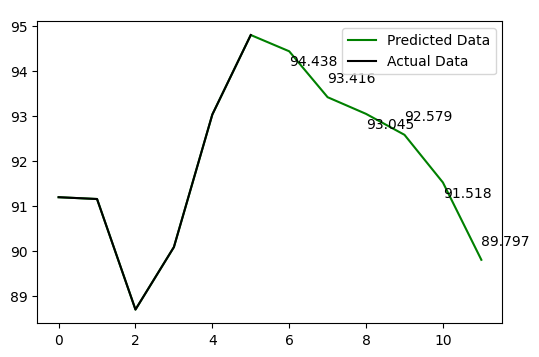

Training ended for ATVI
65

Training started for MAR
Epoch 1/7
1/1 - 0s - loss: 0.0135
Epoch 2/7
1/1 - 0s - loss: 8.5636e-04
Epoch 3/7
1/1 - 0s - loss: 0.0079
Epoch 4/7
1/1 - 0s - loss: 0.0093
Epoch 5/7
1/1 - 0s - loss: 0.0110
Epoch 6/7
1/1 - 0s - loss: 0.0039
Epoch 7/7
1/1 - 0s - loss: 9.0966e-04
((1, 8, 1), (1, 1, 1), 'MAR')


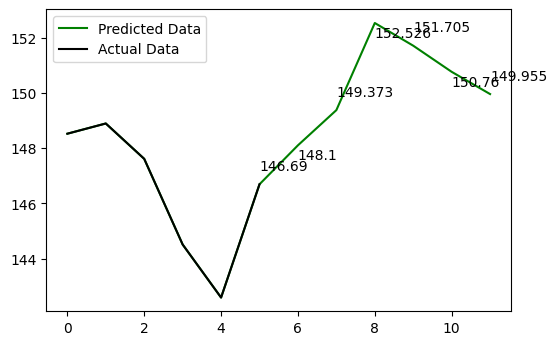

Training ended for MAR
66

Training started for LVS
Epoch 1/7
1/1 - 0s - loss: 0.9590
Epoch 2/7
1/1 - 0s - loss: 0.5849
Epoch 3/7
1/1 - 0s - loss: 0.7660
Epoch 4/7
1/1 - 0s - loss: 0.9267
Epoch 5/7
1/1 - 0s - loss: 0.6820
Epoch 6/7
1/1 - 0s - loss: 0.6719
Epoch 7/7
1/1 - 0s - loss: 0.5585
((1, 8, 1), (1, 1, 1), 'LVS')


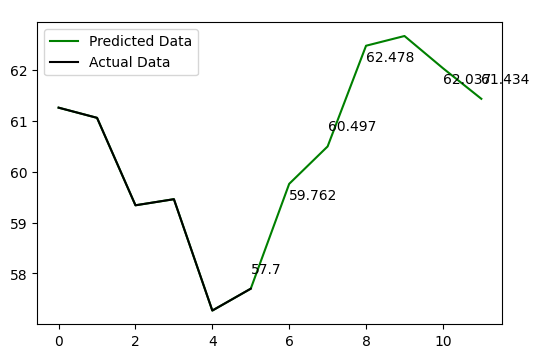

Training ended for LVS
67

Training started for VIAC
Epoch 1/7
1/1 - 0s - loss: 0.0046
Epoch 2/7
1/1 - 0s - loss: 0.0538
Epoch 3/7
1/1 - 0s - loss: 0.0410
Epoch 4/7
1/1 - 0s - loss: 0.0152
Epoch 5/7
1/1 - 0s - loss: 0.0062
Epoch 6/7
1/1 - 0s - loss: 0.0092
Epoch 7/7
1/1 - 0s - loss: 0.0197
((1, 8, 1), (1, 1, 1), 'VIAC')


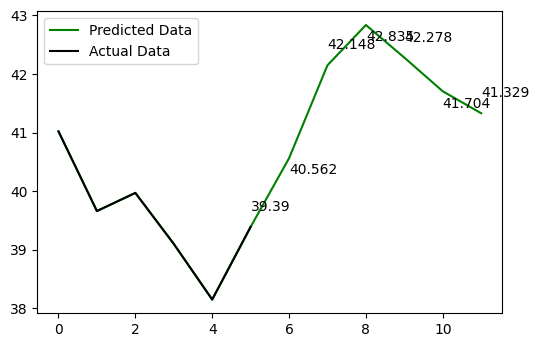

Training ended for VIAC
68

Training started for BTI
Epoch 1/7
1/1 - 0s - loss: 0.0853
Epoch 2/7
1/1 - 0s - loss: 0.0527
Epoch 3/7
1/1 - 0s - loss: 0.1099
Epoch 4/7
1/1 - 0s - loss: 0.0539
Epoch 5/7
1/1 - 0s - loss: 0.0405
Epoch 6/7
1/1 - 0s - loss: 0.0469
Epoch 7/7
1/1 - 0s - loss: 0.0573
((1, 8, 1), (1, 1, 1), 'BTI')


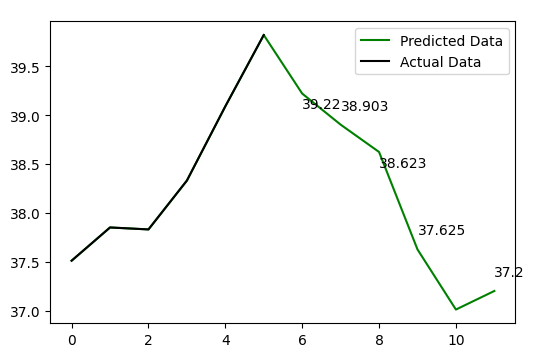

Training ended for BTI
69

Training started for MO
Epoch 1/7
1/1 - 0s - loss: 0.0048
Epoch 2/7
1/1 - 0s - loss: 0.0075
Epoch 3/7
1/1 - 0s - loss: 0.0255
Epoch 4/7
1/1 - 0s - loss: 0.0054
Epoch 5/7
1/1 - 0s - loss: 0.0078
Epoch 6/7
1/1 - 0s - loss: 4.8826e-06
Epoch 7/7
1/1 - 0s - loss: 7.0961e-06
((1, 8, 1), (1, 1, 1), 'MO')


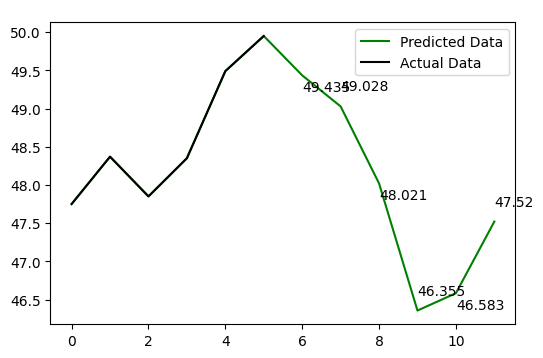

Training ended for MO
70

Training started for DEO
Epoch 1/7
1/1 - 0s - loss: 0.0308
Epoch 2/7
1/1 - 0s - loss: 0.0330
Epoch 3/7
1/1 - 0s - loss: 0.0307
Epoch 4/7
1/1 - 0s - loss: 0.0329
Epoch 5/7
1/1 - 0s - loss: 0.0720
Epoch 6/7
1/1 - 0s - loss: 0.0039
Epoch 7/7
1/1 - 0s - loss: 0.0317
((1, 8, 1), (1, 1, 1), 'DEO')


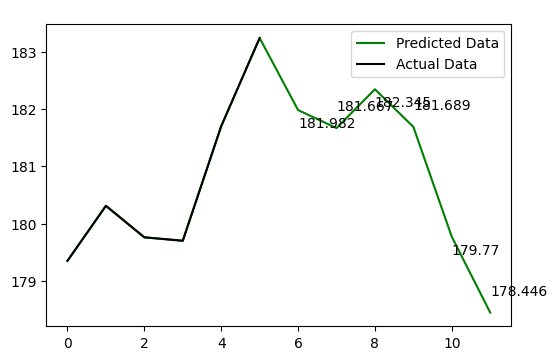

Training ended for DEO
71

Training started for EL
Epoch 1/7
1/1 - 0s - loss: 0.0261
Epoch 2/7
1/1 - 0s - loss: 0.0945
Epoch 3/7
1/1 - 0s - loss: 0.0242
Epoch 4/7
1/1 - 0s - loss: 0.0156
Epoch 5/7
1/1 - 0s - loss: 0.0097
Epoch 6/7
1/1 - 0s - loss: 0.0735
Epoch 7/7
1/1 - 0s - loss: 0.0151
((1, 8, 1), (1, 1, 1), 'EL')


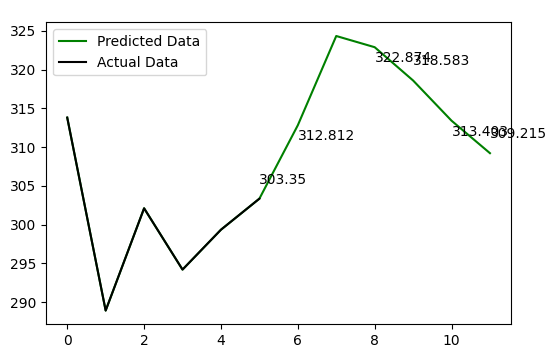

Training ended for EL
72

Training started for BUD
Epoch 1/7
1/1 - 0s - loss: 0.0031
Epoch 2/7
1/1 - 0s - loss: 0.0036
Epoch 3/7
1/1 - 0s - loss: 9.5915e-04
Epoch 4/7
1/1 - 0s - loss: 6.3782e-04
Epoch 5/7
1/1 - 0s - loss: 0.0015
Epoch 6/7
1/1 - 0s - loss: 0.0403
Epoch 7/7
1/1 - 0s - loss: 0.0022
((1, 8, 1), (1, 1, 1), 'BUD')


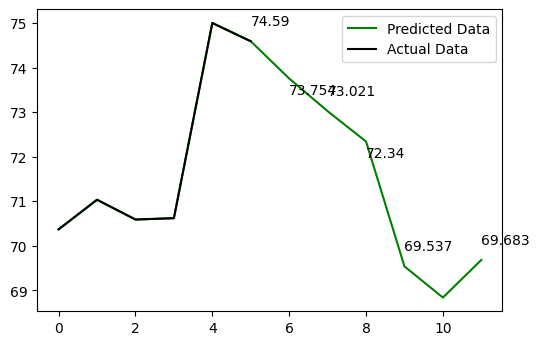

Training ended for BUD
73

Training started for PM
Epoch 1/7
1/1 - 0s - loss: 0.0409
Epoch 2/7
1/1 - 0s - loss: 0.1089
Epoch 3/7
1/1 - 0s - loss: 0.1032
Epoch 4/7
1/1 - 0s - loss: 0.0130
Epoch 5/7
1/1 - 0s - loss: 0.0052
Epoch 6/7
1/1 - 0s - loss: 0.0232
Epoch 7/7
1/1 - 0s - loss: 0.0156
((1, 8, 1), (1, 1, 1), 'PM')


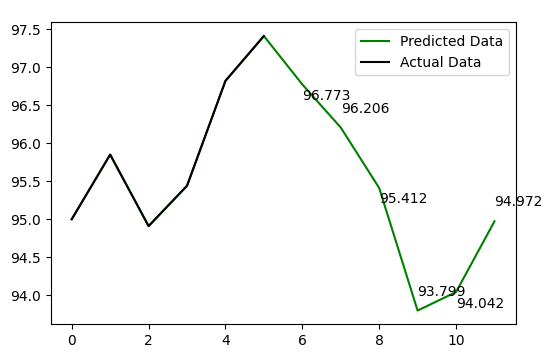

Training ended for PM
74

Training started for PEP
Epoch 1/7
1/1 - 0s - loss: 0.0134
Epoch 2/7
1/1 - 0s - loss: 0.0068
Epoch 3/7
1/1 - 0s - loss: 0.0020
Epoch 4/7
1/1 - 0s - loss: 0.0061
Epoch 5/7
1/1 - 0s - loss: 0.0692
Epoch 6/7
1/1 - 0s - loss: 0.0050
Epoch 7/7
1/1 - 0s - loss: 0.0041
((1, 8, 1), (1, 1, 1), 'PEP')


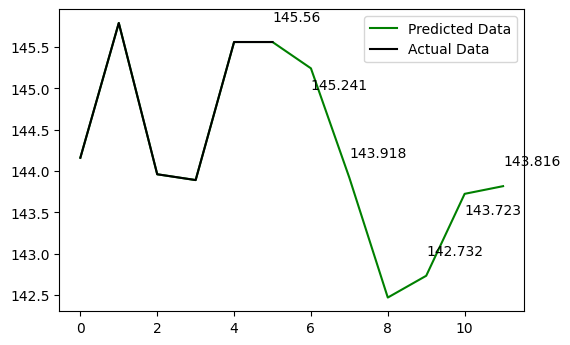

Training ended for PEP
75

Training started for KO
Epoch 1/7
1/1 - 0s - loss: 0.0112
Epoch 2/7
1/1 - 0s - loss: 9.4635e-05
Epoch 3/7
1/1 - 0s - loss: 0.0304
Epoch 4/7
1/1 - 0s - loss: 0.0407
Epoch 5/7
1/1 - 0s - loss: 0.0215
Epoch 6/7
1/1 - 0s - loss: 0.0057
Epoch 7/7
1/1 - 0s - loss: 0.0013
((1, 8, 1), (1, 1, 1), 'KO')


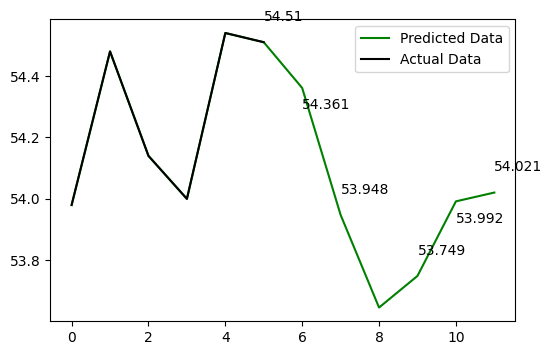

Training ended for KO
76

Training started for PG
Epoch 1/7
1/1 - 0s - loss: 0.0768
Epoch 2/7
1/1 - 0s - loss: 0.0209
Epoch 3/7
1/1 - 0s - loss: 0.0294
Epoch 4/7
1/1 - 0s - loss: 0.0090
Epoch 5/7
1/1 - 0s - loss: 0.0579
Epoch 6/7
1/1 - 0s - loss: 0.0231
Epoch 7/7
1/1 - 0s - loss: 0.0103
((1, 8, 1), (1, 1, 1), 'PG')


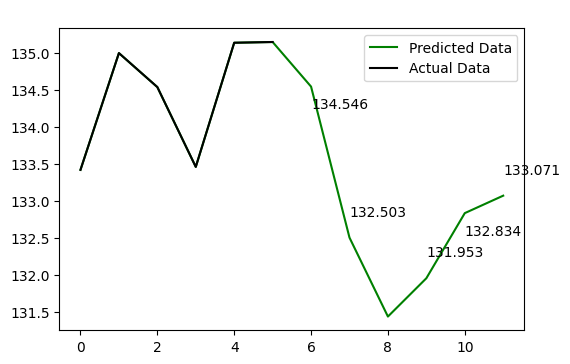

Training ended for PG
77

Training started for GME
Epoch 1/7
1/1 - 0s - loss: 0.0028
Epoch 2/7
1/1 - 0s - loss: 0.0630
Epoch 3/7
1/1 - 0s - loss: 0.1526
Epoch 4/7
1/1 - 0s - loss: 0.1158
Epoch 5/7
1/1 - 0s - loss: 0.0467
Epoch 6/7
1/1 - 0s - loss: 0.0848
Epoch 7/7
1/1 - 0s - loss: 0.1191
((1, 8, 1), (1, 1, 1), 'GME')


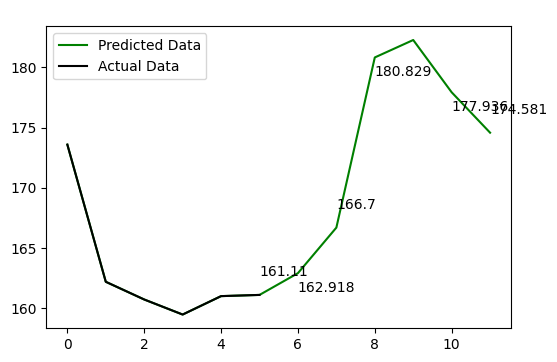

Training ended for GME
78



In [ ]:
cou= 1 
for c in pd.read_excel('/content/drive/MyDrive/SentStock/tickers.xlsx',header=None)[0]:
  print("Training started for "+c)
  c = c.strip()
  sdata =data[f'{c}']['Close'].dropna().values.reshape(-1,1) 
  x_train=[]
  y_train=[]
  
  param[f'{c}']['mean'] = sdata.mean()
  param[f'{c}']['std'] = sdata.std() 
  sdata = norm(sdata ,c )

  x_train.append(sdata[:-1 ] )
  y_train.append(sdata[-1:])

  x_train,y_train = np.array(x_train) , np.array(y_train)
  x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
  train_model(x_train,y_train)

  print((x_train.shape,y_train.shape,c))
  pr = scaled(model.predict(x_train),c)
  d = 1 
  sdata = np.vstack((sdata, model.predict(sdata[d:].reshape((1,8,1)))))
  d+=1

  sdata = np.vstack((sdata,model.predict(sdata[d:].reshape((1,8,1)))))
  d+=1
 
  sdata = np.vstack((sdata,model.predict(sdata[d:].reshape((1,8,1)))))
  d+=1

  sdata = np.vstack((sdata,model.predict(sdata[d:].reshape((1,8,1)))))
  d+=1

  sdata = np.vstack((sdata,model.predict(sdata[d:].reshape((1,8,1)))))
  d+=1

  sdata = np.vstack((sdata,model.predict(sdata[d:].reshape((1,8,1)))))
  sdata = scaled(sdata,c)

  param[f'{c}']['pred'] = pr
  a[f'{c}']['pred'] = pr
  param[f'{c}']['real'] = data[f'{c}']['Close'][-1:]
  a[f'{c}']['real'] = data[f'{c}']['Close'][-1:]
  param[f'{c}']['pred_next'] = sdata[9] 
  a[f'{c}']['pred_next'] = sdata[9]
  a[f'{c}']['pred_next2'] = sdata[10]
  a[f'{c}']['pred_next3'] = sdata[11]
  a[f'{c}']['pred_next4'] = sdata[12]
  a[f'{c}']['pred_next5'] = sdata[13]
  a[f'{c}']['pred_next6'] = sdata[14]
  save_plot(sdata,c,name=f'{c}')
  print("Training ended for "+c)
  print(cou)
  cou+=1
  print()

In [ ]:
sdata.shape

(15, 1)

In [ ]:
param = param.dropna(axis=1,)
a.to_excel('/content/drive/MyDrive/SentStock/preds.xlsx')
param.to_csv('/content/drive/MyDrive/SentStock/param.csv',index=False)

In [ ]:
model.save('/content/drive/MyDrive/SentStock/stock_lstm.keras')